# Trapping SINDy
By Alan Kaptanoglu and Jared Callaham

A very common issue is that models identified by system identification methods typically have no guarantees that the models are numerically or physically stable. This can be addressed with heuristic, data-driven, or analytic closure models, but we have recently directly promoted globally stable models into the system identification itself. This is really nice but two caveats, (1) the regression is nonconvex and there a number of hyperparameters, so this method can be difficult to learn, and (2) in order to promote global stability, one needs an analytic result from stability theory, and the one we use applies only for fluid and plasma flows with energy-preserving, quadratic, nonlinearities. Believe it or not, this energy-preserving structure is quite common.

This example illustrates the use of a new "trapping SINDy" extension on a number of canonical fluid systems. The algorithm searches for globally stable systems with energy-preserving quadratic nonlinearities. The full description can be found in our recent paper: Kaptanoglu, Alan A., et al. "Promoting global stability in data-driven models of quadratic nonlinear dynamics." Physical Review Fluids 6.9 (2021): 094401. This builds off of the new constrained SINDy algorithm based on SR3. The trapping theorem for stability utilized in this SINDy algorithm can be found in Schlegel, M., & Noack, B. R. (2015). On long-term boundedness of Galerkin models. Journal of Fluid Mechanics, 765, 325-352. 

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v1.4.3?filepath=examples/8_trapping_sindy_paper_examples.ipynb)

In [1]:
# Import libraries. Note that the neksuite (pymech)
# package is required for visualization of the 
# vortex shedding example
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pysindy as ps 
from scipy.integrate import solve_ivp
import matplotlib.gridspec as gridspec
import scipy.io as sio
from pysindy.utils import meanfield, oscillator, lorenz, mhd, burgers_galerkin

# ignore user warnings
import warnings
warnings.filterwarnings("ignore")

# Comment out below lines if not doing the vortex shedding
import sys
sys.path.append('data/vonKarman_pod/')
import neksuite as nek

#### The trapping algorithm only applies to fluid and plasma flows with energy-preserving, quadratic nonlinear structure, so we need to explicitly constrain the coefficients to conform to this structure.
Below we define some functions for making these constraints for arbitrary size models. We also define a tensor $\mathbf{P}$ which is required for the algorithm but can be safely ignored by the user. Lastly, we define a number of useful plotting functions, as well as functions for checking the global stability of the identified models, and similar functionality.

In [2]:
# Define some setup and plotting functions
# Build the energy-preserving quadratic nonlinearity constraints
def make_constraints(r):
    q = 0
    N = int((r ** 2 + 3 * r) / 2.0)
    p = r + r * (r - 1) + int(r * (r - 1)*(r - 2) / 6.0)
    constraint_zeros = np.zeros(p)
    constraint_matrix = np.zeros((p, r * N))    
    
    # Set coefficients adorning terms like a_i^3 to zero
    for i in range(r):
        constraint_matrix[q, r * (N - r) + i * (r + 1)] = 1.0
        q = q + 1

    # Set coefficients adorning terms like a_ia_j^2 to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            constraint_matrix[q, r * (N - r + j) + i] = 1.0
            constraint_matrix[q, r * (r + j - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
            q = q + 1
    for i in range(r):
         for j in range(0, i):
            constraint_matrix[q, r * (N - r + j) + i] = 1.0
            constraint_matrix[q, r * (r + i - 1) + j + r * int(j * (2 * r - j - 3) / 2.0)] = 1.0
            q = q + 1

    # Set coefficients adorning terms like a_ia_ja_k to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            for k in range(j + 1, r):
                constraint_matrix[q, r * (r + k - 1) + i + r * int(j * (2 * r - j - 3) / 2.0)] = 1.0
                constraint_matrix[q, r * (r + k - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
                constraint_matrix[q, r * (r + j - 1) + k + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
                q = q + 1
                
    return constraint_zeros, constraint_matrix
    
    
# Use optimal m, and calculate eigenvalues(PW) to see if identified model is stable
def check_stability(r, Xi, sindy_opt, mean_val):
    N = int((r ** 2 + 3 * r) / 2.0)
    opt_m = sindy_opt.m_history_[-1]
    PL_tensor_unsym = sindy_opt.PL_unsym_
    PL_tensor = sindy_opt.PL_
    PQ_tensor = sindy_opt.PQ_
    mPQ = np.tensordot(opt_m, PQ_tensor, axes=([0], [0]))
    P_tensor = PL_tensor - mPQ
    As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
    eigvals, eigvecs = np.linalg.eigh(As)
    print('optimal m: ', opt_m)
    print('As eigvals: ', np.sort(eigvals))
    max_eigval = np.sort(eigvals)[-1]
    min_eigval = np.sort(eigvals)[0]
    L = np.tensordot(PL_tensor_unsym, Xi, axes=([3, 2], [0, 1]))
    Q = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
    d = np.dot(L, opt_m) + np.dot(np.tensordot(Q, opt_m, axes=([2], [0])), opt_m)
    Rm = np.linalg.norm(d) / np.abs(max_eigval)
    Reff = Rm / mean_val
    print('Estimate of trapping region size, Rm = ', Rm)
    print('Normalized trapping region size, Reff = ', Reff)
    

# Plot the SINDy trajectory, trapping region, and ellipsoid where Kdot >= 0
def trapping_region(r, x_test_pred, Xi, sindy_opt, filename):
    
    # Need to compute A^S from the optimal m obtained from SINDy algorithm
    N = int((r ** 2 + 3 * r) / 2.0)
    opt_m = sindy_opt.m_history_[-1]
    PL_tensor_unsym = sindy_opt.PL_unsym_
    PL_tensor = sindy_opt.PL_
    PQ_tensor = sindy_opt.PQ_
    mPQ = np.tensordot(opt_m, PQ_tensor, axes=([0], [0]))
    P_tensor = PL_tensor - mPQ
    As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
    eigvals, eigvecs = np.linalg.eigh(As)
    print('optimal m: ', opt_m)
    print('As eigvals: ', eigvals)

    # Extract maximum and minimum eigenvalues, and compute radius of the trapping region
    max_eigval = np.sort(eigvals)[-1]
    min_eigval = np.sort(eigvals)[0]

    # Should be using the unsymmetrized L
    L = np.tensordot(PL_tensor_unsym, Xi, axes=([3, 2], [0, 1]))
    Q = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
    d = np.dot(L, opt_m) + np.dot(np.tensordot(Q, opt_m, axes=([2], [0])), opt_m)
    Rm = np.linalg.norm(d) / np.abs(max_eigval)

    # Make 3D plot illustrating the trapping region
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(8, 8))
    Y = np.zeros(x_test_pred.shape)
    Y = x_test_pred - opt_m * np.ones(x_test_pred.shape)
        
    Y = np.dot(eigvecs, Y.T).T
    plt.plot(Y[:, 0], Y[:, 1], Y[:, -1], 'k', 
             label='SINDy model prediction with new initial condition', alpha=1.0, linewidth=3)
    h = np.dot(eigvecs, d)

    alpha = np.zeros(r)
    for i in range(r):
        if filename == 'Von Karman' and (i == 2 or i == 3):
            h[i] = 0
        alpha[i] = np.sqrt(0.5) * np.sqrt(np.sum(h ** 2 / eigvals) / eigvals[i])

    shift_orig = h / (4.0 * eigvals)

    # draw sphere in eigencoordinate space, centered at 0
    u, v = np.mgrid[0 : 2 * np.pi : 40j, 0 : np.pi : 20j]
    x = Rm * np.cos(u) * np.sin(v)
    y = Rm * np.sin(u) * np.sin(v)
    z = Rm * np.cos(v)
    
    ax.plot_wireframe(x, y, z, color="b",label=r'Trapping region estimate, $B(m, R_m)$', 
                      alpha=0.5, linewidth=0.5)
    ax.plot_surface(x, y, z, color="b", alpha=0.05)
    ax.view_init(elev=0., azim=30)

    # define ellipsoid
    rx, ry, rz = np.asarray([alpha[0], alpha[1], alpha[-1]])

    # Set of all spherical angles:
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)

    # Add this piece so we can compare with the analytic Lorenz ellipsoid,
    # which is typically defined only with a shift in the "y" direction here.
    if filename == 'Lorenz Attractor':
        shift_orig[0] = 0
        shift_orig[-1] = 0
    x = rx * np.outer(np.cos(u), np.sin(v)) - shift_orig[0]
    y = ry * np.outer(np.sin(u), np.sin(v)) - shift_orig[1]
    z = rz * np.outer(np.ones_like(u), np.cos(v)) - shift_orig[-1]

    # Plot ellipsoid
    ax.plot_wireframe(x, y, z, rstride=5, cstride=5, color='r', 
                      label='Ellipsoid where the system exhibits positive energy growth', 
                      alpha=1.0, linewidth=0.5)
    
    if filename == 'Lorenz Attractor':
        sigma = 10.0
        rho = 28.0
        beta = 8.0 / 3.0
    
        # define analytic ellipsoid in original Lorenz state space
        rx, ry, rz = [np.sqrt(beta * rho), np.sqrt(beta * rho ** 2), rho]

        # Set of all spherical angles:
        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 100)

        # ellipsoid in (x, y, z) coordinate to -> shifted by m
        x = rx * np.outer(np.cos(u), np.sin(v)) - opt_m[0]
        y = ry * np.outer(np.sin(u), np.sin(v)) - opt_m[1]
        z = rz * np.outer(np.ones_like(u), np.cos(v)) + rho - opt_m[-1]

        # Transform into eigencoordinate space
        xyz = np.tensordot(eigvecs, np.asarray([x, y, z]), axes=[1, 0])
        x = xyz[0, :, :]
        y = xyz[1, :, :]
        z = xyz[2, :, :]

        # Plot ellipsoid
        ax.plot_wireframe(x, y, z, rstride=4, cstride=4, color='g', 
                          label=r'Lorenz analytic ellipsoid', 
                          alpha=1.0, linewidth=1.5)
    
    # Adjust plot features and save
    plt.legend(fontsize=16, loc='upper left')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_axis_off()
    plt.show()


# Plot errors between m_{k+1} and m_k and similarly for the model coefficients
def make_progress_plots(r, sindy_opt):
    W = np.asarray(sindy_opt.history_)
    M = np.asarray(sindy_opt.m_history_)
    dW = np.zeros(W.shape[0])
    dM = np.zeros(M.shape[0])
    for i in range(1,W.shape[0]):
        dW[i] = np.sum((W[i, :, :] - W[i - 1, :, :]) ** 2)
        dM[i] = np.sum((M[i, :] - M[i - 1, :]) ** 2)
    plt.figure()
    print(dW.shape, dM.shape)
    plt.semilogy(dW, label=r'Coefficient progress, $\|\xi_{k+1} - \xi_k\|_2^2$')
    plt.semilogy(dM, label=r'Vector m progress, $\|m_{k+1} - m_k\|_2^2$')
    plt.xlabel('Algorithm iterations', fontsize=16)
    plt.ylabel('Errors', fontsize=16)
    plt.legend(fontsize=14)
    PWeigs = np.asarray(sindy_opt.PWeigs_history_)
    plt.figure()
    for j in range(r):
        if np.all(PWeigs[:, j] > 0.0):
            plt.semilogy(PWeigs[:, j], label=r'diag($P\xi)_{' + str(j) + str(j) + '}$')
        else:
            plt.plot(PWeigs[:, j], label=r'diag($P\xi)_{' + str(j) + str(j) + '}$')
        plt.xlabel('Algorithm iterations', fontsize=16)
        plt.legend(fontsize=12)
        plt.ylabel(r'Eigenvalues of $P\xi$', fontsize=16)
    

# Plot first three modes in 3D for ground truth and SINDy prediction
def make_3d_plots(x_test, x_test_pred, filename):
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(8, 8))
    if filename == 'VonKarman':
        ind = -1
    else:
        ind = 2
    plt.plot(x_test[:, 0], x_test[:, 1], x_test[:, ind], 'r', label='true x')
    plt.plot(x_test_pred[:, 0], x_test_pred[:, 1], x_test_pred[:, ind], 'k', label='pred x')
    ax = plt.gca()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_axis_off()
    plt.legend(fontsize=14)
    plt.show()


# Plot the SINDy fits of X and Xdot against the ground truth
def make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, filename):
    fig = plt.figure(figsize=(16, 8))
    spec = gridspec.GridSpec(ncols=2, nrows=r, figure=fig, hspace=0.0, wspace=0.0)
    for i in range(r):
        plt.subplot(spec[i, 0]) #r, 2, 2 * i + 2)
        plt.plot(t, xdot_test[:, i], 'r', label=r'true $\dot{x}_' + str(i) + '$')
        plt.plot(t, xdot_test_pred[:, i], 'k--', label=r'pred $\dot{x}_' + str(i) + '$')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.legend(fontsize=12)
        if i == r - 1:
            plt.xlabel('t', fontsize=18)
        plt.subplot(spec[i, 1])
        plt.plot(t, x_test[:, i], 'r', label=r'true $x_' + str(i) + '$')
        plt.plot(t, x_test_pred[:, i], 'k--', label=r'pred $x_' + str(i) + '$')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.legend(fontsize=12)
        if i == r - 1:
            plt.xlabel('t', fontsize=18)
        
    plt.show()
    

# Make a bar plot of the distribution of SINDy coefficients
# and distribution of Galerkin coefficients for the von Karman street
def make_bar(galerkin9, L, Q):
    bins = np.logspace(-11, 0, 50)
    plt.figure(figsize=(8, 4))
    plt.grid('True')
    galerkin_full = np.vstack((galerkin9['L'].reshape(r ** 2, 1), 
                               galerkin9['Q'].reshape(len(galerkin9['Q'].flatten()), 1)))
    plt.hist(np.abs(galerkin_full), bins=bins, label='POD-9 model')
    sindy_full = np.vstack((L.reshape(r ** 2, 1), 
                            Q.reshape(len(galerkin9['Q'].flatten()), 1)))
    plt.hist(np.abs(sindy_full.flatten()), bins=bins, color='k', label='Trapping SINDy model')
    plt.xscale('log')
    plt.legend(fontsize=14)
    ax = plt.gca()
    ax.set_axisbelow(True)
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.set_yticks([0, 20, 40, 60, 80])
    plt.xlabel('Coefficient values', fontsize=20)
    plt.ylabel('Number of coefficients', fontsize=20)
    plt.title('Histogram of coefficient values', fontsize=20)


# Make Lissajou figures with ground truth and SINDy model on both training and test data
def make_lissajou(r, x_train, x_test, x_train_pred, x_test_pred, filename):
    fig = plt.figure(figsize=(8, 8))
    spec = gridspec.GridSpec(ncols=r, nrows=r, figure=fig, hspace=0.0, wspace=0.0)
    for i in range(r):
        for j in range(i, r):
            plt.subplot(spec[i, j])
            plt.plot(x_train[:, i], x_train[:, j],linewidth=1)
            plt.plot(x_train_pred[:, i], x_train_pred[:, j], 'k--', linewidth=1)
            ax = plt.gca()
            ax.set_xticks([])
            ax.set_yticks([])
            if j == 0:
                plt.ylabel(r'$x_' + str(i) + r'$', fontsize=18)
            if i == r - 1:
                plt.xlabel(r'$x_' + str(j) + r'$', fontsize=18)
        for j in range(i):
            plt.subplot(spec[i, j])
            plt.plot(x_test[:, j], x_test[:, i], 'r', linewidth=1)
            plt.plot(x_test_pred[:, j], x_test_pred[:, i], 'k--', linewidth=1)
            ax = plt.gca()
            ax.set_xticks([])
            ax.set_yticks([])     
            if j == 0:
                plt.ylabel(r'$x_' + str(i) + r'$', fontsize=18)
            if i == r - 1:
                plt.xlabel(r'$x_' + str(j) + r'$', fontsize=18)
    plt.show()
    
    
# Helper function for reading and plotting the von Karman data
def get_velocity(file):
    global nel, nGLL
    field = nek.readnek(file)
    u = np.array([field.elem[i].vel[0, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])
    v = np.array([field.elem[i].vel[1, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])
    return np.concatenate((u, v))


# Helper function for reading and plotting the von Karman data
def get_vorticity(file):
    field = nek.readnek(file)
    vort = np.array([field.elem[i].temp[0, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])
    return vort


# Define von Karman grid
nx = 400
ny = 200
xmesh = np.linspace(-5, 15, nx)
ymesh = np.linspace(-5, 5, ny)
XX, YY = np.meshgrid(xmesh, ymesh)


# Helper function for plotting the von Karman data
def interp(field, method='cubic', mask=(np.sqrt(XX ** 2 + YY ** 2) < 0.5).flatten('C')):
    global Cx, Cy, XX, YY
    """
    field - 1D array of cell values
    Cx, Cy - cell x-y values
    X, Y - meshgrid x-y values
    grid - if exists, should be an ngrid-dim logical that will be set to zer
    """
    ngrid = len(XX.flatten())
    grid_field = np.squeeze( np.reshape( griddata((Cx, Cy), field, (XX, YY), method=method), (ngrid, 1)) )
    if mask is not None:
        grid_field[mask] = 0
    return grid_field


# Helper function for plotting the von Karman data
def plot_field(field, clim=[-5, 5], label=None):
    """Plot cylinder field with masked circle"""
    im = plt.imshow(field, cmap='RdBu', vmin=clim[0], vmax=clim[1], origin='lower', extent=[-5, 15, -5, 5], 
                    interpolation='gaussian', label=label)
    cyl = plt.Circle((0, 0), 0.5, edgecolor='k', facecolor='gray')
    plt.gcf().gca().add_artist(cyl)
    return im


# Initialize quadratic SINDy library, with custom ordering to be consistent with the constraint
library_functions = [lambda x:x, lambda x, y:x * y, lambda x:x ** 2]
library_function_names = [lambda x:x, lambda x, y:x + y, lambda x:x + x]
sindy_library = ps.CustomLibrary(library_functions=library_functions, function_names=library_function_names)

# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-15
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-10

# Mean field model
Often the trajectories of nonlinear dynamical systems whose linear parts have some stable directions will approach slow manifolds of reduced dimension with respect to the full state space.
As an example of this behavior, consider the following linear-quadratic system originally proposed by Noack et al. (2003) as a simplified model of the von Karman vortex shedding problem:
$$
    \frac{d}{dt}\begin{bmatrix}x \\ y \\z \end{bmatrix}
    = \begin{bmatrix} \mu & -1 & 0 \\1 & \mu & 0 \\ 0 & 0 & -1 \\ \end{bmatrix}
    \begin{bmatrix} x \\ y \\z \end{bmatrix}
    + \begin{bmatrix}- xz \\ - yz \\ x^2 + y^2\end{bmatrix} = \mathbf{L}\mathbf{x} + \mathbf{Q}\mathbf{xx},
$$
where $\mathbf{L}$ and $\mathbf{Q}$ denote the linear and quadratic parts of the model, respectively.

Systems of this form commonly arise in PDEs with a pair of unstable eigenmodes represented by $x$ and $y$.
The third variable $z$ models the effects of mean-field deformations due to nonlinear self-interactions of the instability modes.
The linear component is the generic linear part of a system undergoing a supercritical Hopf bifurcation at $\mu = 0$; for $\mu \ll 1$ trajectories quickly approach the parabolic manifold defined by $z = x^2 + y^2$.
All solutions asymptotically approach a stable limit cycle on which $z = x^2 + y^2 = \mu$.
It can be shown that $\mathbf{m} = [0, 0, \mu+\epsilon]$, $\epsilon > 0$ produces a negative definite matrix defined through

$$
\begin{align}
    \mathbf{A}^S = \mathbf{L}^S - \mathbf{m}\mathbf{Q} = \begin{bmatrix}
    -\epsilon & 0 & 0 \\
    0 & -\epsilon & 0 \\
    0 & 0 & -1 
    \end{bmatrix},
\end{align}
$$
where $\mathbf{L}^S = \mathbf{L} + \mathbf{L}^T$ is the symmetrized linear part of the model. From the Schlegel and Noack trapping theorem (and our trapping SINDy paper), this negative definite matrix allows us to conclude that this system exhibits a trapping region. We can show this analytically, and illustrate below our algorithm can discover it.

 Iteration | Data Error | Stability Error |   L1 Error
           0  4.19973e-09  9.46797e-10  0.00000e+00
         500  4.19973e-09  5.78205e-13  0.00000e+00
        1000  4.19973e-09  1.01269e-13  0.00000e+00
        1500  4.19973e-09  3.78522e-14  0.00000e+00
        2000  4.19973e-09  1.92543e-14  0.00000e+00
        2500  4.19973e-09  1.15361e-14  0.00000e+00
        3000  4.19973e-09  7.64501e-15  0.00000e+00
        3500  4.19973e-09  5.42333e-15  0.00000e+00
        4000  4.19973e-09  4.04038e-15  0.00000e+00
        4500  4.19973e-09  3.12315e-15  0.00000e+00
(x0)' = 0.010 x0 + -1.000 x1 + -1.000 x0x2
(x1)' = 1.000 x0 + 0.010 x1 + -1.000 x1x2
(x2)' = -1.000 x2 + 1.000 x0x0 + 1.000 x1x1


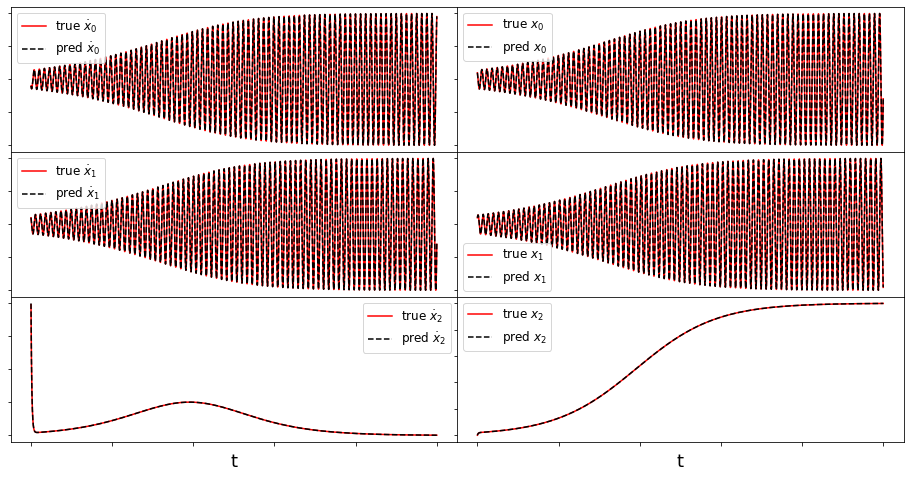

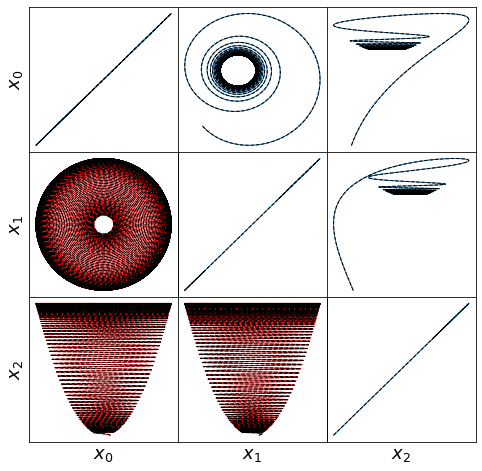

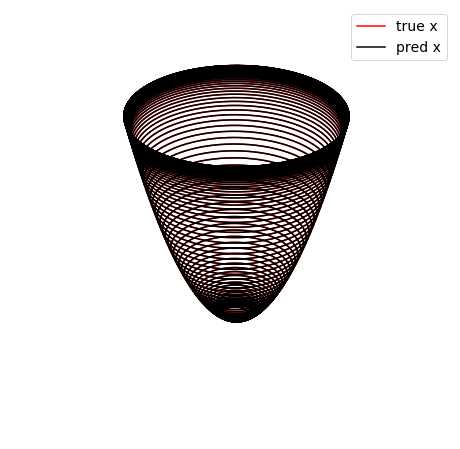

Frobenius Error =  0.005932260505499515
optimal m:  [-0.08532587 -0.04093775  1.32026727]
As eigvals:  [-1.31732858 -1.31027701 -0.99295083]
Estimate of trapping region size, Rm =  1.3299418085602355
Normalized trapping region size, Reff =  218.2079874576934
Frobenius coefficient error =  1.8547523089586973e-05
Time-averaged derivative error =  1.9020245008458243e-12


In [6]:
# define parameters
r = 3
mu = 1e-2
dt = 0.01
T = 500
t = np.arange(0, T + dt, dt)
t_span = (t[0], t[-1])
x0 = np.random.rand(3) - 0.5
x_train = solve_ivp(meanfield, t_span, x0, t_eval=t, args=(mu,), **integrator_keywords).y.T
x0 = (mu, mu, 0)
x_test = solve_ivp(meanfield, t_span, x0, t_eval=t, args=(mu,), **integrator_keywords).y.T

# define hyperparameters
threshold = 0.0
eta = 1e10
max_iter = 5000

constraint_zeros, constraint_matrix = make_constraints(r)

# run trapping SINDy algorithm
sindy_opt = ps.TrappingSR3(threshold=threshold, eta=eta,
                           max_iter=max_iter, gamma=-1,
                           constraint_lhs=constraint_matrix,
                           constraint_rhs=constraint_zeros,
                           constraint_order="feature",
                           )

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t, quiet=True)
model.print()
Xi = model.coefficients().T
xdot_test = model.differentiate(x_test, t=t)
xdot_test_pred = model.predict(x_test)
x_train_pred = model.simulate(x_train[0, :], t, integrator_kws=integrator_keywords)
x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)

# plotting and analysis
make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, 'meanfield')
make_lissajou(r, x_train, x_test, x_train_pred, x_test_pred, 'meanfield')
make_3d_plots(x_test, x_test_pred, 'meanfield')
E_pred = np.linalg.norm(x_test - x_test_pred) / np.linalg.norm(x_test)
print('Frobenius Error = ', E_pred)
mean_val = np.mean(x_test_pred, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_stability(r, Xi, sindy_opt, mean_val)

# compute relative Frobenius error in the model coefficients
Xi_meanfield = np.zeros(Xi.shape)
Xi_meanfield[:r, :r] = np.asarray([[0.01, -1, 0], [1, 0.01, 0], [0, 0, -1]]).T
Xi_meanfield[r + 1, 0] = -1
Xi_meanfield[r + 2, 1] = -1
Xi_meanfield[r + 3, 2] = 1
Xi_meanfield[r + 4, 2] = 1
coef_pred = np.linalg.norm(Xi_meanfield - Xi) / np.linalg.norm(Xi_meanfield)
print('Frobenius coefficient error = ', coef_pred)

# Compute time-averaged dX/dt error
deriv_error = np.zeros(xdot_test.shape[0])
for i in range(xdot_test.shape[0]):
    deriv_error[i] = np.dot(xdot_test[i, :] - xdot_test_pred[i, :], 
                            xdot_test[i, :] - xdot_test_pred[i, :])  / np.dot(
                            xdot_test[i, :], xdot_test[i, :])
print('Time-averaged derivative error = ', np.nanmean(deriv_error))

Awesome! The trapping algorithm gets exactly the right model and produces a negative definite matrix,
$$\mathbf{A}^S = \begin{bmatrix}
    -1.32 & 0 & 0 \\
    0 & -1.31 & 0 \\
    0 & 0 & -1 
    \end{bmatrix},$$
i.e. it identifies $\epsilon \approx 1.3$ from above. Note that with different algorithm hyperparameters it will produce different $\epsilon$, since the algorithm only cares that the matrix is negative definite (i.e. only cares about the largest eigenvalue), not the precise value of $\epsilon$. Moreover, these eigenvalues can change as the algorithm converges further. Lastly, it produces an estimate of the radius of the trapping region, which we plot below.

However, since $\epsilon > 0$ can be any value, this means that 

optimal m:  [-0.08532587 -0.04093775  1.32026727]
As eigvals:  [-1.31732858 -1.31027701 -0.99295083]


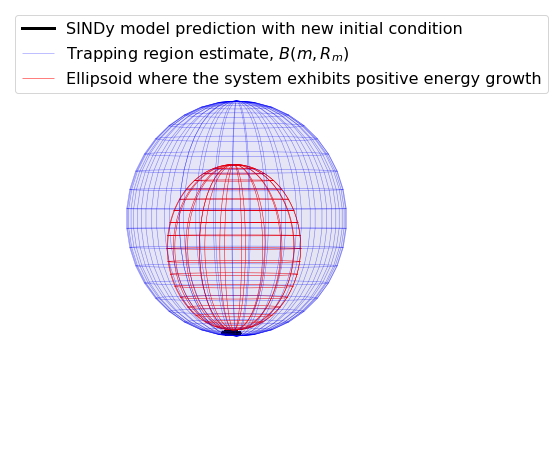

In [7]:
# make 3D illustration of the trapping region
trapping_region(r, x_test_pred, Xi, sindy_opt, 'Mean Field Model')



# Atmospheric oscillator model
Here we briefly look at a more complicated Lorenz-like system of coupled oscillators that is motivated from atmospheric dynamics. The model is

$$
\begin{align}
\label{eq:oscillator}
    \frac{d}{dt}\begin{bmatrix}
    x \\ 
    y \\
    z \\
    \end{bmatrix} = \begin{bmatrix}
    \mu_1 & 0 & 0 \\
    0 & \mu_2 & \omega \\
    0 & -\omega & \mu_2 
    \end{bmatrix}\begin{bmatrix} 
    x \\ 
    y \\
    z 
    \end{bmatrix}
    +
    \begin{bmatrix}
    \sigma xy \\
    \kappa yz + \beta z^2 - \sigma x^2 \\
    - \kappa y^2 - \beta yz
    \end{bmatrix}.
\end{align}
$$

For comparison, we assume the parameter choices in Tuwankotta et al. (2006), $\mu_1 = 0.05$, $\mu_2 = -0.01$, $\omega = 3$, $\sigma = 1.1$, $\kappa = -2$, and $\beta = -6$, for which a limit cycle is known to exist. Again, the algorithm shows straightforward success finding a model with a trapping region, for a range of hyperparameter values.

 Iteration | Data Error | Stability Error |   L1 Error
           0  6.79669e-05  2.00376e-07  0.00000e+00
         500  6.79669e-05  1.62862e-10  0.00000e+00
        1000  6.79669e-05  8.72838e-11  0.00000e+00
        1500  6.79669e-05  6.32876e-11  0.00000e+00
        2000  6.79669e-05  5.28300e-11  0.00000e+00
        2500  6.79669e-05  4.75421e-11  0.00000e+00
        3000  6.79669e-05  4.46436e-11  0.00000e+00
        3500  6.79669e-05  4.29796e-11  0.00000e+00
        4000  6.79669e-05  4.19978e-11  0.00000e+00
        4500  6.79669e-05  4.14089e-11  0.00000e+00
(x0)' = 0.050 x0 + 1.100 x0x1
(x1)' = -0.010 x1 + 3.000 x2 + -2.000 x1x2 + -1.100 x0x0 + -4.999 x2x2
(x2)' = -3.000 x1 + -0.010 x2 + 4.999 x1x2 + 2.000 x1x1


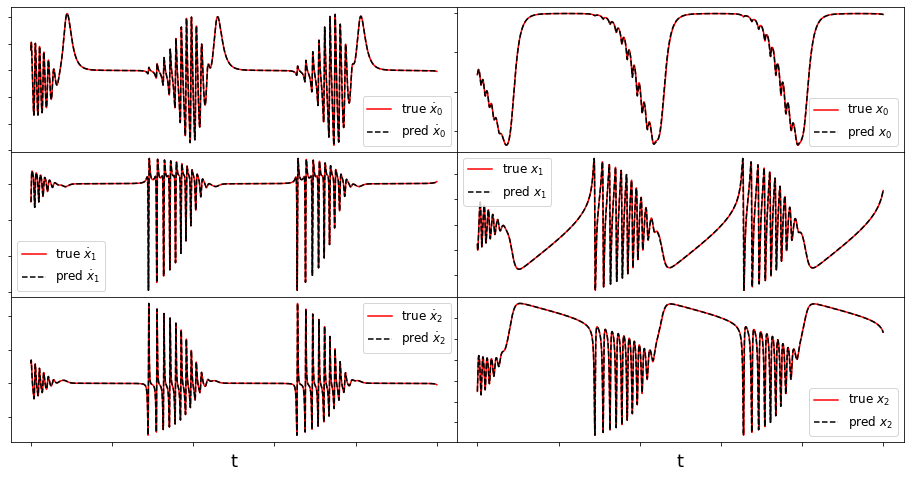

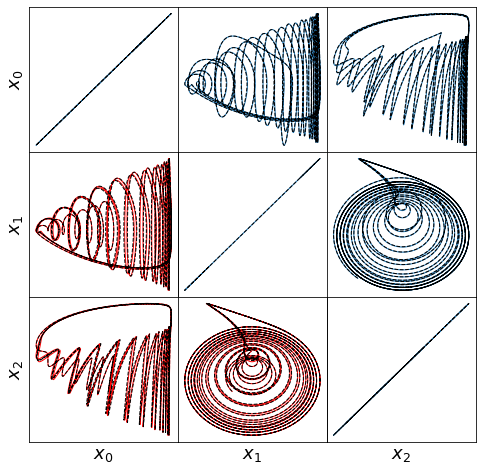

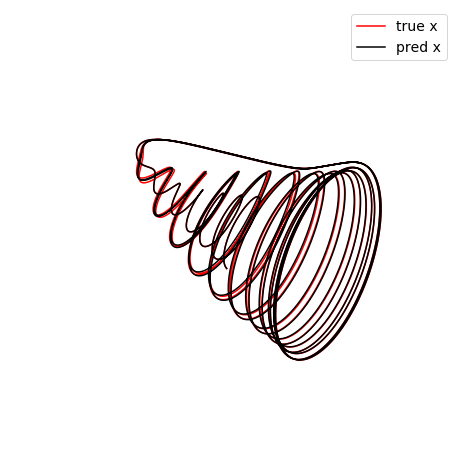

(5001,) (5001,)
Frobenius error =  0.056144626081428416
optimal m:  [-0.04783749 -0.92794716  0.37114111]
As eigvals:  [-5.39145051 -0.97127068 -0.00938849]
Estimate of trapping region size, Rm =  319.45111345400187
Normalized trapping region size, Reff =  636.8026345442051
Frobenius coefficient error =  0.00011183375042667136
Time-averaged derivative error =  1.1390895261296306e-07


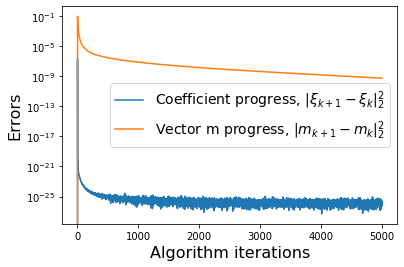

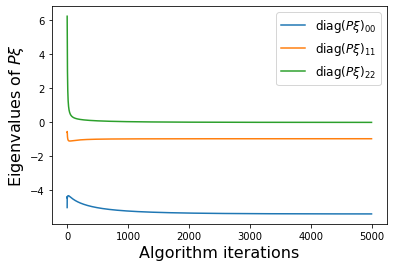

In [9]:
# define parameters
r = 3
sigma = 1.1
beta = -5.0
eps = 0.01
k1 = 5
k2 = 1
mu1 = eps*k1
mu2 = -eps*k2
alpha = -2.0
omega = 3.0

# Make training and testing data
dt = 0.005
T = 250
t = np.arange(0, T + dt, dt)
t_span = (t[0], t[-1])
x0 = np.random.rand(3) - 0.5
x_train = solve_ivp(oscillator, t_span, x0, t_eval=t, 
                    args=(mu1, mu2, omega, alpha, beta, sigma), 
                    **integrator_keywords).y.T
x0 = np.random.rand(3) - 0.5
x_test = solve_ivp(oscillator, t_span, x0, t_eval=t,
                   args=(mu1, mu2, omega, alpha, beta, sigma), 
                   **integrator_keywords).y.T

# define hyperparameters
eta = 1.0e8

# run trapping SINDy, reusing previous threshold, max_iter and constraints
sindy_opt = ps.TrappingSR3(threshold=threshold, eta=eta, max_iter=max_iter,
                           constraint_lhs=constraint_matrix,
                           constraint_rhs=constraint_zeros,
                           constraint_order="feature",
                           )
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t, quiet=True)
model.print()
Xi = model.coefficients().T
xdot_test = model.differentiate(x_test, t=t)
xdot_test_pred = model.predict(x_test)
x_train_pred = model.simulate(x_train[0, :], t, integrator_kws=integrator_keywords)
x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)

# plotting and analysis
make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, 'oscillator')
make_lissajou(r, x_train, x_test, x_train_pred, x_test_pred, 'oscillator')
make_3d_plots(x_test, x_test_pred, 'oscillator')
make_progress_plots(r, sindy_opt)
E_pred = np.linalg.norm(x_test - x_test_pred) / np.linalg.norm(x_test)
print('Frobenius error = ', E_pred)
mean_val = np.mean(x_test_pred, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_stability(r, Xi, sindy_opt, mean_val)

# compute relative Frobenius error in the model coefficients
Xi_oscillator = np.zeros(Xi.shape)
Xi_oscillator[:r, :r] = np.asarray([[0.05, 0, 0], [0, -0.01, 3.0], [0, -3.0, -0.01]]).T
Xi_oscillator[r, 0] = 1.1
Xi_oscillator[r + 2, 1] = -2
Xi_oscillator[r + 3, 1] = -1.1
Xi_oscillator[r + 5, 1] = -5
Xi_oscillator[r + 2, 2] = 5
Xi_oscillator[r + 4, 2] = 2
coef_pred = np.linalg.norm(Xi_oscillator - Xi) / np.linalg.norm(Xi_oscillator)
print('Frobenius coefficient error = ', coef_pred)

# Compute time-averaged dX/dt error
deriv_error = np.zeros(xdot_test.shape[0])
for i in range(xdot_test.shape[0]):
    deriv_error[i] = np.dot(xdot_test[i, :] - xdot_test_pred[i, :], 
                            xdot_test[i, :] - xdot_test_pred[i, :])  / np.dot(
                            xdot_test[i, :], xdot_test[i, :])
print('Time-averaged derivative error = ', np.nanmean(deriv_error))

optimal m:  [-0.04783749 -0.92794716  0.37114111]
As eigvals:  [-5.39145051 -0.97127068 -0.00938849]


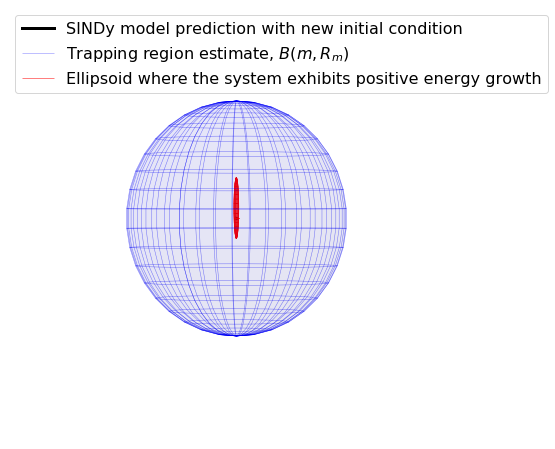

In [10]:
# make 3D illustration of the trapping region
trapping_region(r, x_test_pred, Xi, sindy_opt, 'Atmospheric Oscillator')

### We identified a very accurate and provably stable model but the trapping region looks way too big... what's going on here?
The estimate for the size of the trapping region is based on the smallest eigenvalue of $\mathbf{A}^S$. But this system has a big scale-separation, leading to $\lambda_1 = -0.01$ (while $\lambda_3 = -5.4$) and an estimate of the trapping region of $R_m = d/\lambda_1 \approx 300$. This is because our estimate of the trapping region comes from the worst case scenario.  

# Lorenz model
The Lorenz system originates from a simple fluid model of atmospheric dynamics from Lorenz et al. (1963).
This system is likely the most famous example of chaotic, nonlinear behavior despite the somewhat innocuous system of equations,

$$
\begin{align}
    \frac{d}{dt}\begin{bmatrix}
    x \\ 
    y \\
    z \\
    \end{bmatrix} &= \begin{bmatrix}
    -\sigma & \sigma & 0 \\
    \rho & -1 & 0 \\
    0 & 0 & -\beta
    \end{bmatrix}
    \begin{bmatrix}
    x \\
    y \\
    z
    \end{bmatrix}
    +
    \begin{bmatrix}
    0 \\
    -xz \\
    xy
    \end{bmatrix}, \qquad
    \mathbf{A}^S = \begin{bmatrix}
    -\sigma & \frac{1}{2}(\rho+\sigma - m_3) & \frac{1}{2}m_2 \\
    \frac{1}{2}(\rho+\sigma - m_3) & -1 & 0 \\
    \frac{1}{2}m_2 & 0 & -\beta 
    \end{bmatrix}.
\end{align}
$$

For Lorenz's choice of parameters, $\sigma = 10$, $\rho = 28$, $\beta  = 8/3$, this system is known to exhibit a stable attractor. For $\mathbf{m} = [0,m_2,\rho+\sigma]$ ($m_1$ does not contribute to $\mathbf{A}^S$ so we set it to zero),

$$
\begin{align}
    \mathbf{A}^S &= \begin{bmatrix}
    -\sigma & 0 & \frac{1}{2}m_2 \\
    0 & -1 & 0 \\
    \frac{1}{2}m_2 & 0 & -\beta 
    \end{bmatrix}, \qquad
    \lambda_1 = -1, \qquad \lambda_{\pm} = -\frac{1}{2}\left[\beta+\sigma \mp \sqrt{m_2^2 + (\beta-\sigma)^2}\right],
\end{align}
$$

so that if $\lambda_{\pm} < 0$, then $-2\sqrt{\sigma\beta} < m_2 < 2\sqrt{\sigma\beta}$. 
Our algorithm can successfully identify the optimal $\mathbf{m}$, and can be used to identify the inequality bounds on $m_2$ for stability. 

 Iteration | Data Error | Stability Error |   L1 Error
           0  6.48317e+02  1.27247e+03  0.00000e+00
       10000  6.47158e+02  1.41375e-03  0.00000e+00
(x0)' = -9.863 x0 + 9.932 x1 + -0.004 x2 + -0.001 x0x1 + -0.003 x0x2 + 0.001 x1x2 + 0.001 x1x1
(x1)' = 27.729 x0 + -0.893 x1 + 0.008 x2 + -0.001 x0x1 + -0.992 x0x2 + -0.002 x1x2 + 0.001 x0x0
(x2)' = 0.002 x0 + -0.004 x1 + -2.660 x2 + 0.991 x0x1 + 0.003 x0x0 + 0.002 x1x1


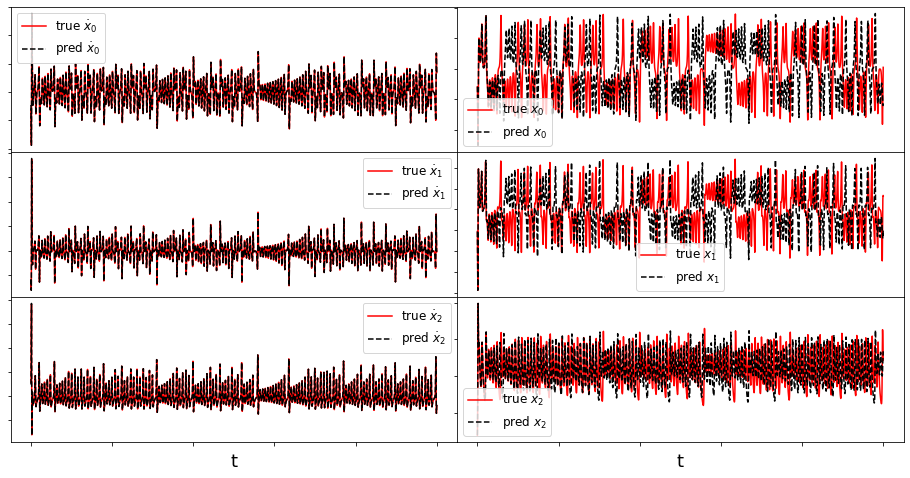

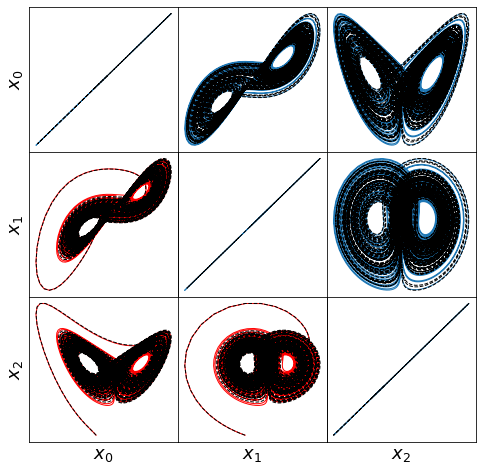

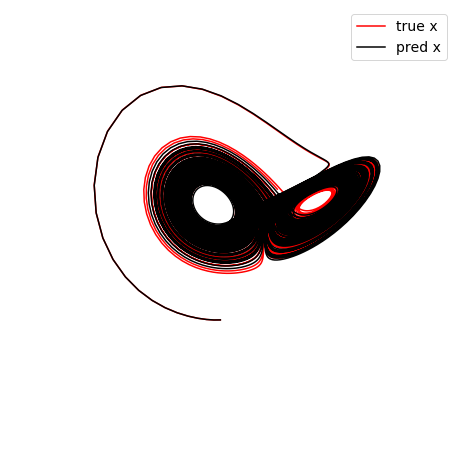

(18567,) (18567,)
optimal m:  [-1.05114135 -0.11530017 37.98851855]
As eigvals:  [-9.97357415 -2.65978586 -0.98382077]
Estimate of trapping region size, Rm =  106.93165017771749
Normalized trapping region size, Reff =  4.53574635125729
Frobenius error =  0.7249126719632907
Frobenius coefficient error =  0.010441383214459343
Time-averaged derivative error =  1.2046438542556793e-05


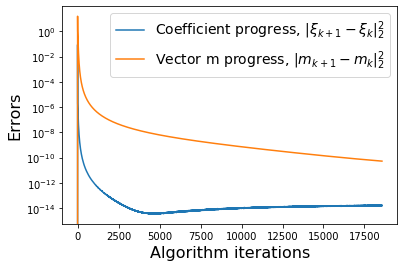

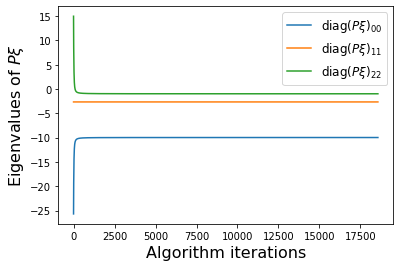

In [12]:
# define parameters
r = 3

# make training and testing data
dt = 0.01
T = 100
t = np.arange(0, T + dt, dt)
t_span = (t[0], t[-1])
x0 = [1, -1, 20]
x_train = solve_ivp(lorenz, t_span, x0, t_eval=t, **integrator_keywords).y.T
x0 = (np.random.rand(3) - 0.5) * 30
x_test = solve_ivp(lorenz, t_span, x0, t_eval=t, **integrator_keywords).y.T

# define hyperparameters
threshold = 0
max_iter = 10000
eta = 1.0e-1

# See below code if using threshold !=0 or alternative trapping SINDy algorithm
# elif relax_optim and threshold != 0:
#     max_iter = 1000
#     eta = 1.0e-1
# else:
#     max_iter = 20
#     eta = 1.0e-4

alpha_m = 2e-1 * eta  # default is 1e-2 * eta so this speeds up the code here
accel = True  # use acceleration for the update of (m, A), not necessary but can sometimes give speedups

# run trapping SINDy
sindy_opt = ps.TrappingSR3(threshold=threshold, eta=eta, alpha_m=alpha_m,
                           accel=accel, max_iter=max_iter, gamma=-1,
                           constraint_lhs=constraint_matrix,
                           constraint_rhs=constraint_zeros,
                           constraint_order="feature",
                           )
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t, quiet=True)
model.print()

Xi = model.coefficients().T
xdot_test = model.differentiate(x_test, t=t)
xdot_test_pred = model.predict(x_test)
x_train_pred = model.simulate(x_train[0, :], t, integrator_kws=integrator_keywords)
x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)

# plotting and analysis
make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, 'lorenz')
make_lissajou(r, x_train, x_test, x_train_pred, x_test_pred, 'lorenz')
make_3d_plots(x_test, x_test_pred, 'lorenz')
make_progress_plots(r, sindy_opt)
mean_val = np.mean(x_test_pred, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_stability(r, Xi, sindy_opt, mean_val)
E_pred = np.linalg.norm(x_test - x_test_pred) / np.linalg.norm(x_test)
print('Frobenius error = ', E_pred)

# compute relative Frobenius error in the model coefficients
sigma = 10
rho = 28
beta = 8.0 / 3.0
Xi_lorenz = np.zeros(Xi.shape)
Xi_lorenz[:r, :r] = np.asarray([[-sigma, sigma, 0], [rho, -1, 0], [0, 0, -beta]]).T
Xi_lorenz[r + 1, 1] = -1
Xi_lorenz[r, 2] = 1
coef_pred = np.linalg.norm(Xi_lorenz - Xi) / np.linalg.norm(Xi_lorenz)
print('Frobenius coefficient error = ', coef_pred)

# Compute time-averaged dX/dt error
deriv_error = np.zeros(xdot_test.shape[0])
for i in range(xdot_test.shape[0]):
    deriv_error[i] = np.dot(xdot_test[i, :] - xdot_test_pred[i, :], 
                            xdot_test[i, :] - xdot_test_pred[i, :])  / np.dot(
                            xdot_test[i, :], xdot_test[i, :])
print('Time-averaged derivative error = ', np.nanmean(deriv_error))

# Visualizing the trapping region for Lorenz
Below, we plot the SINDy-identified trapping region (red) and the analytic trapping region (cyan) for the Lorenz system. The estimate for the trapping region (blue) correctly encloses the Lorenz attractor, and the red ellipsoid of positive energy growth. We can see that trajectories starting outside of this region monotonically fall into this region and remain forever, and the red and cyan ellipsoids agree well.

optimal m:  [-0.79067218 -0.11485324 38.03179323]
As eigvals:  [-9.97382656 -2.66003265 -0.98513975]


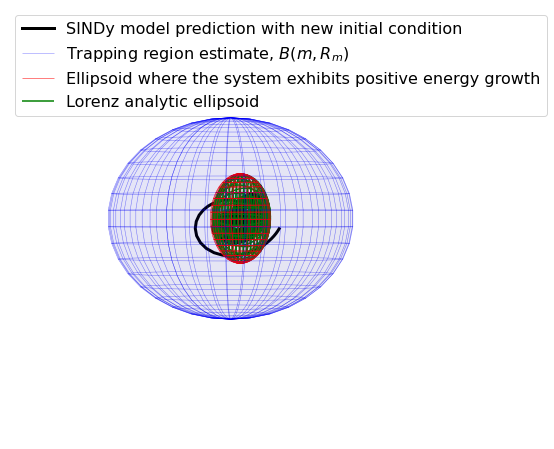

In [8]:
# make 3D illustration of the trapping region
trapping_region(r, x_test_pred, Xi, sindy_opt, 'Lorenz Attractor')

### Some of these plots are different looking than in the Trapping SINDy paper
This is because (1) there were a few small errors in the original code and (2) we are now plotting the trapping regions not in the $\mathbf{a}(t)$ or $\mathbf{y}(t) = \mathbf{a}(t) - \mathbf{m}$ spaces, but instead in the $\mathbf{z}(t)$ eigenvector coordinates of $\mathbf{A}^S$, where the definition of the ellipsoid makes the most sense, and (3) the paper examples are typically generated from fully converged solutions, waiting for additional iterations. See the paper for a review of this notation.

# MHD model
Magnetohydrodynamics exhibit quadratic nonlinearities that are often energy-preserving with typical boundary conditions. 
We consider a simple model of the nonlinearity in 2D incompressible MHD, which can be obtained from Fourier-Galerkin projection onto a single triad of wave vectors. For the wave vectors $(1,1)$, $(2,-1)$, and $(3,0)$ and no background magnetic field, the Carbone and Veltri (1992) system is 

$$
\begin{align}
\label{eq:simpleMHD_model}
    \begin{bmatrix}
    \dot{V}_1 \\
    \dot{V}_2 \\
    \dot{V}_3 \\ 
    \dot{B}_1 \\
    \dot{B}_2 \\
    \dot{B}_3 \\
    \end{bmatrix} = \begin{bmatrix}
    -2 \nu & 0 & 0 & 0 & 0 & 0 \\
    0 & -5 \nu & 0 & 0 & 0 & 0 \\
    0 & 0 & -9 \nu & 0 & 0 & 0 \\
    0 & 0 & 0 & -2 \mu & 0 & 0 \\
    0 & 0 & 0 & 0 & -5 \mu & 0 \\
    0 & 0 & 0 & 0 & 0 & -9 \mu \\
    \end{bmatrix}\begin{bmatrix}
    V_1 \\ 
    V_2 \\ 
    V_3 \\ 
    B_1 \\ 
    B_2 \\ 
    B_3 
    \end{bmatrix} + \begin{bmatrix}
    4(V_2V_3 - B_2B_3) \\ 
    -7(V_1V_3 - B_1B_3) \\ 
    3(V_1V_2 - B_1B_2) \\ 
    2(B_3V_2 - V_3B_2) \\ 
    5(V_3B_1 - B_3V_1) \\ 
    9(V_1B_2 - B_1V_2) \\ 
    \end{bmatrix},
\end{align}
$$

where $\nu \geq 0$ is the viscosity and $\mu \geq 0$ is the resistivity. Without external forcing, this system is trivially stable (it dissipates to zero), so we consider the inviscid limit $\nu = \mu = 0$. The system is then Hamiltonian and our algorithm correctly converges to $\mathbf{m} = 0$, $\mathbf{A}^S = 0$. The reason our algorithm converges to the correct behavior is because it is still minimizing $\dot{K}$; in this case trapping SINDy minimizes to $\dot{K} \approx 0$ and can make no further improvement.

In [13]:
# define parameters
r = 6
nu = 0.0  # viscosity
mu = 0.0  # resistivity

# define training and testing data
dt = 0.001
T = 50
t = np.arange(0, T + dt, dt)
t_span = (t[0], t[-1])
x0 = (np.random.rand(6) - 0.5)
x_train = solve_ivp(mhd, t_span, x0, t_eval=t, **integrator_keywords).y.T
x0 = (np.random.rand(6) - 0.5)
x_test = solve_ivp(mhd, t_span, x0, t_eval=t, **integrator_keywords).y.T

# define hyperparameters
threshold = 0.0
relax_optim = False
if relax_optim:
    max_iter = 50000
    eta = 1.0e3
    alpha_m = 5.0e-5 * eta
else:
    max_iter = 2
    eta = 1.0e5
    
constraint_zeros, constraint_matrix = make_constraints(r)

# run trapping SINDy with "relax_optim = False" here, uses CVXPY for all the updates 
# so this tends to be much slower but often need far fewer algorithm iterations.
# For this problem, a single (very slow) update is all that is needed!
sindy_opt = ps.TrappingSR3(threshold=threshold, eta=eta,
                           max_iter=max_iter,
                           gamma=-0.1, eps_solver=1e-5,
                           constraint_lhs=constraint_matrix,
                           constraint_rhs=constraint_zeros,
                           constraint_order="feature",
                           relax_optim=False)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t, quiet=True)
model.print()
Xi = model.coefficients().T
xdot_test = model.differentiate(x_test, t=t)
xdot_test_pred = model.predict(x_test)
x_train_pred = model.simulate(x_train[0, :], t, integrator_kws=integrator_keywords)
x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)

# plotting and analysis
make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, 'mhd')
make_lissajou(r, x_train, x_test, x_train_pred, x_test_pred, 'mhd')
make_3d_plots(x_test, x_test_pred, 'mhd')
make_progress_plots(r, sindy_opt)
mean_val = np.mean(x_test_pred, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_stability(r, Xi, sindy_opt, mean_val)
E_pred = np.linalg.norm(x_test - x_test_pred) / np.linalg.norm(x_test)
print(E_pred)

# compute relative Frobenius error in the model coefficients
Xi_mhd = np.zeros(Xi.shape)
Xi_mhd[r + 5, 0] = 4.0
Xi_mhd[r + 14, 0] = -4.0
Xi_mhd[r + 1, 1] = -7
Xi_mhd[r + 13, 1] = 7.0
Xi_mhd[r, 2] = 3.0
Xi_mhd[r + 12, 2] = -3.0
Xi_mhd[r + 8, 3] = 2.0
Xi_mhd[r + 10, 3] = -2.0
Xi_mhd[r + 4, 4] = -5.0
Xi_mhd[r + 9, 4] = 5.0
Xi_mhd[r + 3, 5] = 9.0
Xi_mhd[r + 6, 5] = -9.0
model.print(precision=2)
coef_pred = np.linalg.norm(Xi_mhd - Xi) / np.linalg.norm(Xi_mhd)

# Compute time-averaged dX/dt error
deriv_error = np.zeros(xdot_test.shape[0])
for i in range(xdot_test.shape[0]):
    deriv_error[i] = np.dot(xdot_test[i, :] - xdot_test_pred[i, :], 
                            xdot_test[i, :] - xdot_test_pred[i, :])  / np.dot(
                            xdot_test[i, :], xdot_test[i, :])
print('Time-averaged derivative error = ', np.nanmean(deriv_error))

 Iteration | Data Error | Stability Error |   L1 Error
Failure:Interrupted
Solver failed, setting coefs to zeros
WARN: A->p (column pointers) not strictly increasing, column 1 empty
WARN: A->p (column pointers) not strictly increasing, column 2 empty
WARN: A->p (column pointers) not strictly increasing, column 3 empty
WARN: A->p (column pointers) not strictly increasing, column 4 empty
WARN: A->p (column pointers) not strictly increasing, column 5 empty
WARN: A->p (column pointers) not strictly increasing, column 6 empty
           0  3.31791e+04  3.00000e-07  0.00000e+00


KeyboardInterrupt: 

# Forced Burger's Equation
The viscous Burgers' equation has long served as a simplified one-dimensional turbulence analogue (Burgers/Hopf 1948). The forced, viscous Burgers' equation on a periodic domain $x \in [0,2\pi)$ is:

$$
\begin{align}
\label{eq:burgers}
    \dot{u} &= -(U + u)\partial_x u + \nu \partial_{xx}^2u + g(x,t),
\end{align}
$$

where $\nu$ is viscosity and the constant $U$ models mean-flow advection. 
We project this system onto a Fourier basis and assume constant forcing acting on the largest scale, i.e. $g(x, t) = \sigma \left( a_1(t) e^{ix} + a_{-1}(t) e^{-ix} \right)$ as in Noack and Schlegel et al. (2008).
After Fourier projection, the evolution of the coefficients $a_k(t)$ is given by the Galerkin dynamics

$$
\begin{equation}
\label{eq:burgers_galerkin}
    \dot{a}_k = \left( \delta_{|k|1} \sigma - \nu k^2  - ikU \right) a_k - \sum_{\ell=-r}^{r} i \ell a_{\ell} a_{k - \ell}.
\end{equation}
$$

In the subcritical case $\sigma < \nu$ the origin of this system is stable to all perturbations and all solutions decay on long times.
However, in the supercritical case $\sigma > \nu$ the excess energy input from the forcing cascades to the smaller dissipative scales. 
The absolute equilibrium limit $\sigma = \nu = 0$ has a Hamiltonian structure; at long times the coefficients approach thermodynamic equilibrium and equipartition of energy. For the supercritical condition $\sigma > \nu$, the trapping SINDy algorithm does not converge to a negative definite $\mathbf{A}^S$ because this system does not exhibit effective nonlinearity. 

 Iteration | Data Error | Stability Error |   L1 Error
           0  6.75638e-02  2.47951e-05  0.00000e+00
         500  6.71456e-02  1.55444e-05  0.00000e+00
        1000  6.72532e-02  1.49145e-05  0.00000e+00
        1500  6.73377e-02  1.46654e-05  0.00000e+00
        2000  6.73937e-02  1.45627e-05  0.00000e+00
        2500  6.74299e-02  1.45215e-05  0.00000e+00
        3000  6.74531e-02  1.45058e-05  0.00000e+00
        3500  6.74678e-02  1.45001e-05  0.00000e+00
        4000  6.74770e-02  1.44985e-05  0.00000e+00
        4500  6.74829e-02  1.44982e-05  0.00000e+00


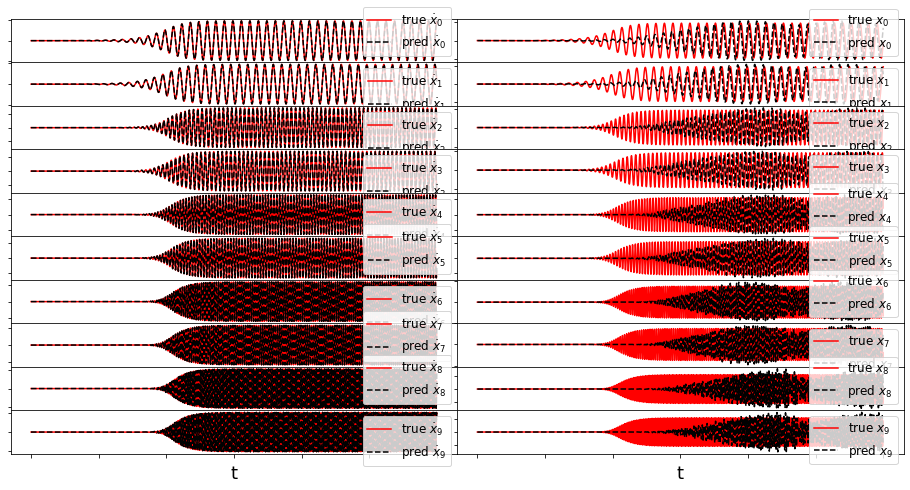

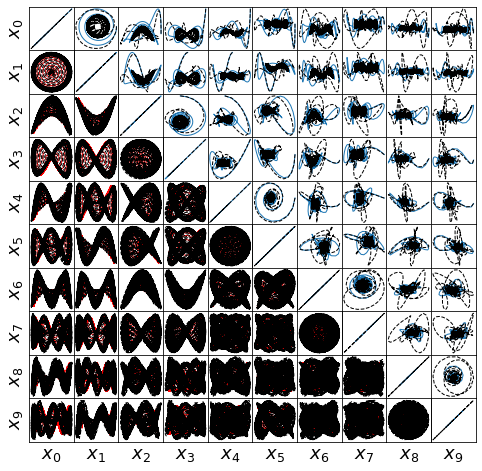

(5001,) (5001,)
optimal m:  [-0.16329131  0.05374414 -0.01629398  0.04827606  0.00358464  0.04528977
  0.05294108 -0.01891394 -0.01736772 -0.04201082]
As eigvals:  [-0.67739203 -0.65688736 -0.47998005 -0.39079314 -0.1951007  -0.15009548
 -0.02378795  0.00208503  0.06664207  0.08207788]
Estimate of trapping region size, Rm =  4.986395116020493
Normalized trapping region size, Reff =  1158.1843401733984
0.9961897512818896
Time-averaged derivative error =  0.0012104990218977983


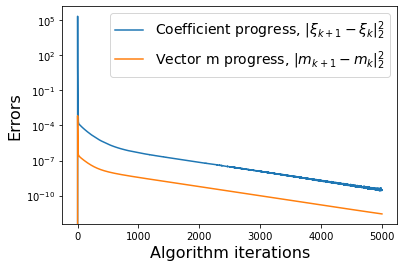

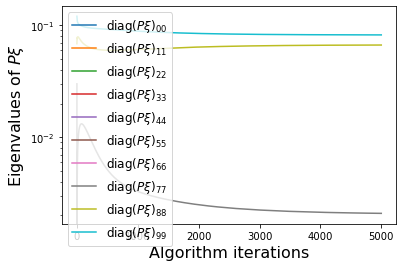

In [10]:
# define parameters and load in training DNS data
tstart = 0
tend = 3000
Burgers = sio.loadmat('data/burgers_highres2.mat')
skip = 1
nu = Burgers['nu'].item()
sigma = Burgers['sigma'].item()
U = Burgers['U'].item()
t = (Burgers['t'].flatten())[tstart:tend:skip]
x_train = Burgers['a']
u_train = Burgers['u'][:, tstart:tend:skip]
theta = Burgers['x'].flatten()
spatial_modes_train = Burgers['theta']

del Burgers
r = 10
x_train = x_train[:r, tstart:tend:skip].T

# Load in testing DNS data
Burgers = sio.loadmat('data/burgers_highres1.mat')
x_test = Burgers['a']
u_test = Burgers['u'][:, tstart:tend:skip]
spatial_modes_test = Burgers['theta']
del Burgers
x_test = x_test[:r, tstart:tend:skip].T

# define hyperparameters
relax_optim = True
if relax_optim:
    max_iter = 5000
    eta = 5.0e2 
else:
    max_iter = 5
    eta = 1e5
threshold = 0.0
alpha_m = 1e-2 * eta
alpha_A = 1.0 * eta

constraint_zeros, constraint_matrix = make_constraints(r)

# run trapping SINDy, initial guess of zeros can speed this up
sindy_opt = ps.TrappingSR3(threshold=threshold, eta=eta, alpha_m=alpha_m, alpha_A=alpha_A, accel=False, 
                           tol_m=1e-10, m0=np.zeros(r),
                           max_iter=max_iter, tol=1e-20, gamma=-0.01,
                           constraint_lhs=constraint_matrix,
                           constraint_rhs=constraint_zeros,
                           constraint_order="feature",
                           relax_optim=relax_optim)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t, quiet=True)
Xi = model.coefficients().T
xdot_test = model.differentiate(x_test, t=t)
xdot_test_pred = model.predict(x_test)
x_train_pred = model.simulate(x_train[0, :], t, integrator_kws=integrator_keywords)
x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)

# plotting and analysis
make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, 'burgers')
make_lissajou(r, x_train, x_test, x_train_pred, x_test_pred, 'burgers')
make_progress_plots(r, sindy_opt)
mean_val = np.mean(x_test_pred, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_stability(r, Xi, sindy_opt, mean_val)
E_pred = np.linalg.norm(x_test - x_test_pred) / np.linalg.norm(x_test)
print(E_pred)

# Compute time-averaged dX/dt error
deriv_error = np.zeros(xdot_test.shape[0])
for i in range(xdot_test.shape[0]):
    deriv_error[i] = np.dot(xdot_test[i, :] - xdot_test_pred[i, :], 
                            xdot_test[i, :] - xdot_test_pred[i, :])  / np.dot(
                            xdot_test[i, :], xdot_test[i, :])
print('Time-averaged derivative error = ', np.nanmean(deriv_error))

We have obtained a decent looking model for the POD modes of the Burgers' equation. As mentioned earlier, it cannot be made into a provably stable model because of a lack of effective nonlinearity. We also neglected to print out the final model here, because it is nonsparse and not very enlightening. However, below we can plot the full $u(x, t)$ PDE data from the POD model reconstructions.

### Plot reconstructions of u(x,t) from ground truth and trapping SINDy model
We will plot the DNS data, the reconstruction of the DNS data using the 10 POD modes obtained from that same data (no forecasting being done here), and then the reconstruction of the DNS data from the forecasted 10-mode SINDy model.

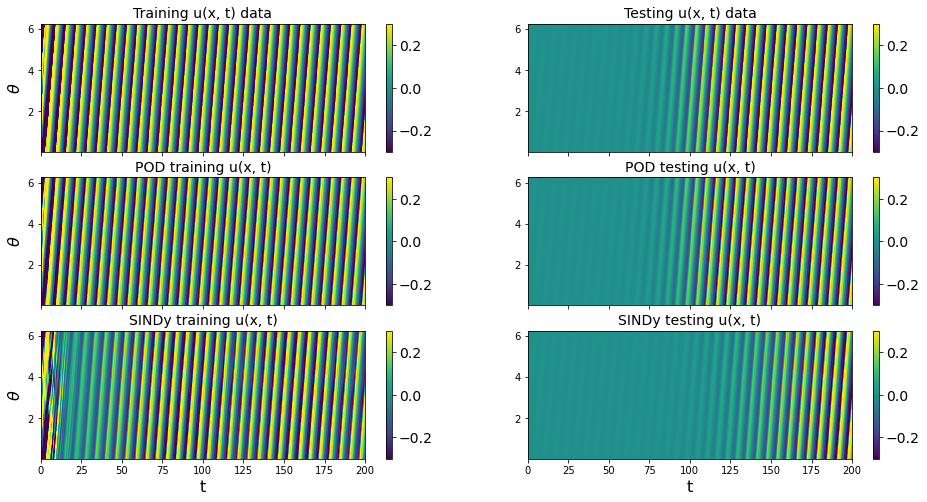

In [11]:
from matplotlib.colors import LogNorm
recon1 = np.dot(spatial_modes_train[:r, :].T, x_train.T)
recon2 = np.dot(spatial_modes_test[:r, :].T, x_test.T)
recon3 = np.dot(spatial_modes_train[:r, :].T, x_train_pred.T)
recon4 = np.dot(spatial_modes_test[:r, :].T, x_test_pred.T)
data = [u_train, u_test, recon1, recon2, recon3, recon4]
data_labels = ['Training u(x, t) data', 'Testing u(x, t) data',
               'POD training u(x, t)', 'POD testing u(x, t)',
               'SINDy training u(x, t)', 'SINDy testing u(x, t)']

plt.figure(figsize=(16, 8))
# Plot results on the training data
for i in range(6):
    plt.subplot(3, 2, i + 1)
    plt.pcolor(t, theta, data[i], vmin=-0.3, vmax=0.3)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.xlim(0, 200)
    ax = plt.gca()
    plt.title(data_labels[i], fontsize=14)
    if i < 4:
        ax.set_xticklabels([])
    else:
        plt.xlabel('t', fontsize=16)
    if i % 2 == 0:
        plt.ylabel(r'$\theta$', fontsize=16)

plt.show()

### Capturing the transient is important to get the phase correct
Often is difficult to capture the transient behavior of a system with system identification techniques. If one doesn't get it just right, the transient timing will be incorrect, leading an overall phase error.

For instance, for this Burgers' equation SINDy model, plotting the shockwave indicates that the transient is not captured well and this leads to a late-time phase shift with respect to the original data.

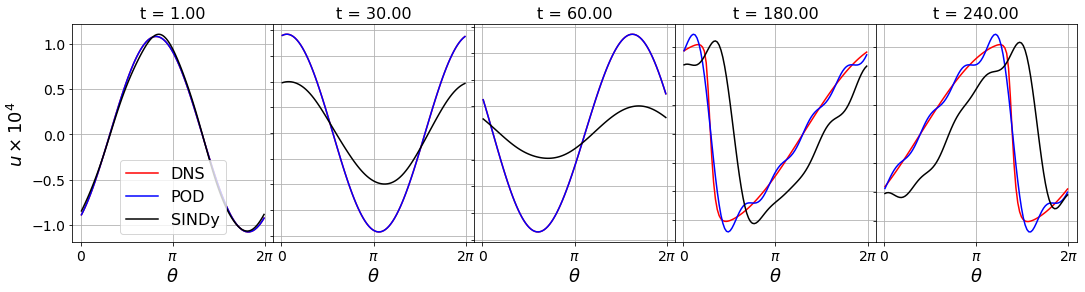

In [12]:
tslices = [10, 300, 600, 1800, 2400]
fig = plt.figure(figsize=(18, 4))
spec = gridspec.GridSpec(ncols=len(tslices), nrows=1, figure=fig, hspace=0.0, wspace=0.0)
for i, tslice in enumerate(tslices):
    plt.subplot(spec[0, i])
    plt.plot(theta, u_test[:, tslice] * 1e4, 'r', label='DNS')
    plt.plot(theta, recon2[:, tslice] * 1e4, 'b', label='POD')
    plt.plot(theta, recon4[:, tslice] * 1e4, 'k', label='SINDy')
    ax = plt.gca()
    ax.set_xticks([0, np.pi, 2 * np.pi])
    # ax.set_xticklabels([])
    # ax.set_yticks([])
    plt.title('t = {0:.2f}'.format(t[tslice]), fontsize=16)
    plt.grid(True)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    ax.set_xticklabels(['0', r'$\pi$', r'$2\pi$'])
    plt.xlabel(r'$\theta$', fontsize=18)
    if i == 0:
        plt.legend(fontsize=16)
        plt.ylabel(r'$u \times 10^{4}$', fontsize=18)
    else:
        ax.set_yticklabels([])
plt.show()

### Forced Burgers' system is not effectively nonlinear
The last bit of information we will get from this system is checking if the analytic model exhibits effective nonlinearity, a requirement for the Schlegel and Noack trapping theorem to hold. 

Using a simulated annealing algorithm, we can show that even the analytic 10D Galerkin Noack and Schlegel et al. (2008) model does not exhibit a $\mathbf{m}$ such that $\mathbf{A}$^S is negative definite. This is because the nonlinearity is not 'effective'. 

In [13]:
from scipy.optimize import dual_annealing as anneal_algo


# define analytic galerkin model for quadratic nonlinear systems
def galerkin_model(a, L, Q):
    """RHS of POD-Galerkin model, for time integration"""
    return (L @ a) + np.einsum('ijk,j,k->i', Q, a, a)


# get analytic L and Q operators and galerkin model
L, Q = burgers_galerkin(sigma, nu, U)
rhs = lambda t, a : galerkin_model(a, L, Q)

# Generate initial condition from unstable eigenvectors
lamb, Phi = np.linalg.eig(L)
idx = np.argsort(-np.real(lamb))
lamb, Phi = lamb[idx], Phi[:, idx]
a0 = np.real( 1e-4*Phi[:, :2] @ np.random.random((2)) )

# define parameters
dt = 1e-3
r = 10
t_sim = np.arange(0, 300, dt)
t_span = (t_sim[0], t_sim[-1])
x_train = solve_ivp(rhs, t_span, a0, t_eval=t_sim, **integrator_keywords).y.T


# define the objective function to be minimized by simulated annealing
def obj_function(m, L_obj, Q_obj):
    As = L_obj - np.tensordot(m, Q_obj,axes=([0], [0]))
    eigvals, eigvecs = np.linalg.eigh(As)
    return(eigvals[-1])


# Search between -500, 500 for each component of m
boundvals = np.zeros((r, 2))
boundmax = 500
boundmin = -500
boundvals[:, 0] = boundmin
boundvals[:, 1] = boundmax

# run simulated annealing and display optimal m and 
# the corresponding objective function value
Ls = 0.5 * (L + L.T)
algo_sol = anneal_algo(obj_function, bounds=boundvals, args=(Ls, Q), maxiter=2000)
opt_m = algo_sol.x
opt_energy = algo_sol.fun
opt_result = algo_sol.message
print('Simulated annealing ended because ' + opt_result[0])
print('Optimal m = ', opt_m)
print('Algorithm managed to reduce the largest eigenvalue of A^S to eig1 = ', opt_energy)
print('Since the largest eigenvalue cannot be made negative, '
      'we conclude that effective nonlinearity does not hold for this system.')

Simulated annealing ended because Maximum number of iteration reached
Optimal m =  [-2.87370154e-03 -2.02815883e-03  1.13605754e-05 -1.60904708e-05
  7.98543126e-04 -6.29974809e-04 -3.76837434e-04  3.59307402e-04
 -5.91893008e-04  3.89936544e-04]
Algorithm managed to reduce the largest eigenvalue of A^S to eig1 =  0.07501519072143335
Since the largest eigenvalue cannot be made negative, we conclude that effective nonlinearity does not hold for this system.


# Von Karman shedding behind circular cylinder, Re = 100
In many cases, the wake behind a bluff body is characterized by a periodic vortex shedding phenomenon known as a von Karman street.
The two-dimensional incompressible flow past a cylinder is a stereotypical example of such behavior.

The transient energy growth and saturation amplitude of this instability mode is of particular interest and has historically posed a significant modeling challenge.
Noack et al. (2003) used an 8-mode POD basis that was augmented with a ninth "shift mode" parameterizing a mean flow deformation. The 9-mode quadratic Galerkin model does resolve the transient dynamics, nonlinear stability mechanism, and post-transient oscillation, accurately reproducing all of the key physical features of the vortex street. Moreover, in Schlegel and Noack (2015) stability of the quadratic model was proven with $m_9 = m_\text{shift} = \epsilon$, $\epsilon > 1$, and $m_i = 0$ for $i = \{1,...,8\}$. Note that POD-Galerkin models will generally weakly satisfy the effective nonlinearity criteria, although the addition of the shift-mode is a complication.

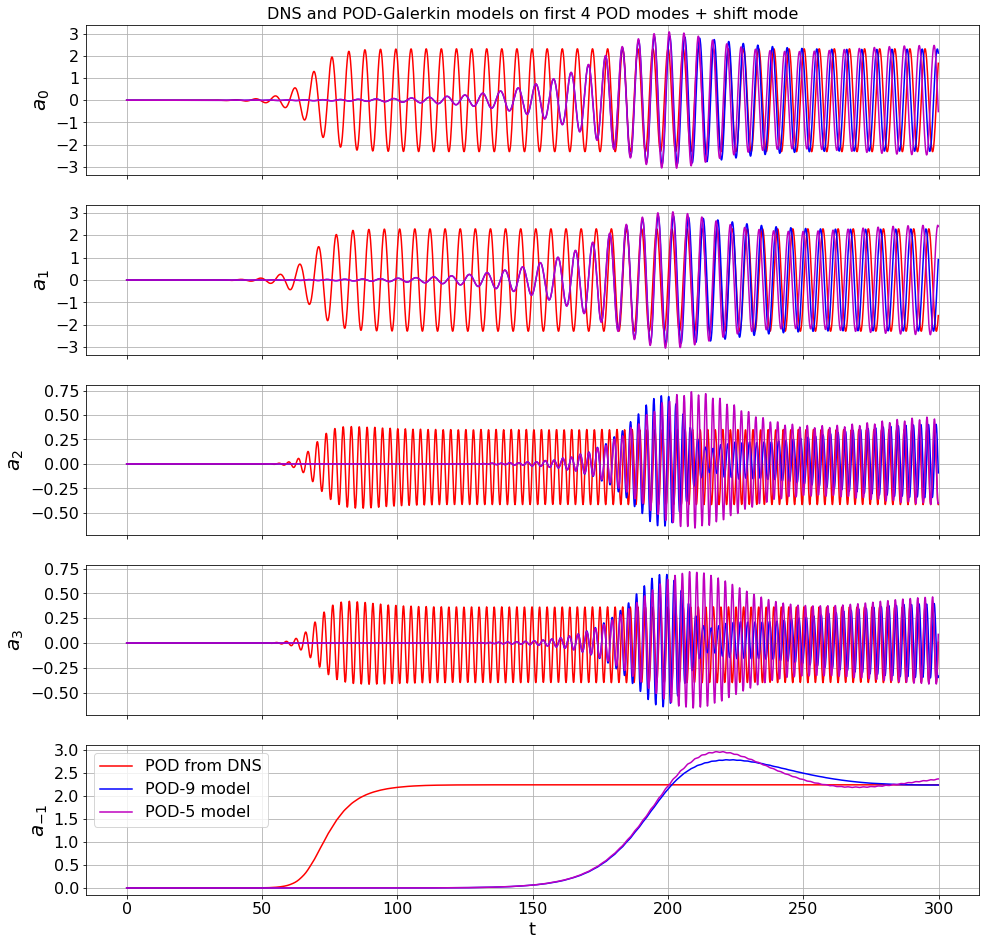

In [14]:
# define parameters and load in POD modes obtained from DNS
a = np.loadtxt('data/vonKarman_pod/vonKarman_a.dat')
t = a[:, 0]
r = 5
if r < 9:
    a_temp = a[:, 1:r]
    a_temp = np.hstack((a_temp, a[:, -1].reshape(3000, 1)))
    a = a_temp
else:
    a = a[:, 1:r + 1]
tbegin = 0
tend = 3000
skip = 1
t = t[tbegin:tend:skip]
a = a[tbegin:tend:skip, :]
dt = t[1] - t[0]

# define the POD-Galerkin models from Noack (2003)
galerkin3 = sio.loadmat('data/vonKarman_pod/galerkin3.mat')
model3 = lambda t, a: galerkin_model(a, galerkin3['L'], galerkin3['Q'])
galerkin9 = sio.loadmat('data/vonKarman_pod/galerkin9.mat')

# make the Galerkin model nonlinearity exactly energy-preserving rather than just approximately
gQ = 0.5 * (galerkin9['Q'] + np.transpose(galerkin9['Q'], [0, 2, 1]))
galerkin9['Q'] = gQ - (gQ + np.transpose(gQ, [1, 0, 2]) + np.transpose(
    gQ, [2, 1, 0]) + np.transpose(
    gQ, [0, 2, 1]) + np.transpose(
    gQ, [2, 0, 1]) + np.transpose(
    gQ, [1, 2, 0])) / 6.0
model9 = lambda t, a: galerkin_model(a, galerkin9['L'], galerkin9['Q'])

# time base for simulating Galerkin models
t_sim = np.arange(0, 500, dt)

# Generate initial condition from unstable eigenvectors
lamb, Phi = np.linalg.eig(galerkin9['L'])
idx = np.argsort(-np.real(lamb))
lamb, Phi = lamb[idx], Phi[:, idx]
a0 = np.zeros(9)
a0[0] = 1e-3
# np.real( 1e-3*Phi[:, :2] @ np.random.random((2)) )

# get the 5D POD-Galerkin coefficients
inds5 = np.ix_([0, 1, 2, 3, -1], [0, 1, 2, 3, -1])
galerkin5 = {}
galerkin5['L'] = galerkin9['L'][inds5]
inds5 = np.ix_([0, 1, 2, 3, -1], [0, 1, 2, 3, -1], [0, 1, 2, 3, -1])
galerkin5['Q'] = galerkin9['Q'][inds5]
model5 = lambda t, a: galerkin_model(a, galerkin5['L'], galerkin5['Q'])

# make the 3D, 5D, and 9D POD-Galerkin trajectories
t_span = (t[0], t[-1])
a_galerkin3 = solve_ivp(model3, t_span, a0[:3], t_eval=t, **integrator_keywords).y.T
a_galerkin5 = solve_ivp(model5, t_span, a0[:5], t_eval=t, **integrator_keywords).y.T
adot_galerkin5 = np.gradient(a_galerkin5, axis=0) / (t[1] - t[0])
a_galerkin9 = solve_ivp(model9, t_span, a0[:9], t_eval=t, **integrator_keywords).y.T
adot_galerkin9 = np.gradient(a_galerkin9, axis=0) / (t[1] - t[0])

# plot the first 4 POD modes + the shift mode
mode_numbers = [0, 1, 2, 3, -1]
plt.figure(figsize=(16, 16))
for i in range(r):
    plt.subplot(r, 1, i + 1)
    if i == 0:
        plt.title('DNS and POD-Galerkin models on first 4 POD modes + shift mode', fontsize=16)
    plt.plot(t, a[:, mode_numbers[i]], 'r', label='POD from DNS')
    plt.plot(t, a_galerkin9[:, mode_numbers[i]], 'b', label='POD-9 model')
    plt.plot(t, a_galerkin5[:, mode_numbers[i]], 'm', label='POD-5 model')
    ax = plt.gca()
    #ax.set_yticklabels([])
    plt.ylabel(r'$a_{' + str(mode_numbers[i]) + '}$', fontsize=20)
    plt.grid(True)
    if i == r - 1:
        plt.xlabel('t', fontsize=18)
        plt.legend(loc='upper left', fontsize=16)
    else:
        ax.set_xticklabels([])
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
a0 = np.zeros(r)
a0[0] = 1e-3

### Initial guess for A and m from previous runs speed up the convergence
Okay, it is time to use Trapping SINDy to fit a model to the POD modes in the Von Karman vortex wake. However, this optimization is quite slow right now, so instead we ran the optimization for a long time, saved the progress through the variables A_guess and m_guess, and we can just run a last few iterations here.

In [15]:
# initial guesses for the 5D trapping SINDy models
A_guess = np.asarray([[-0.09549166,  0.06690551,  0.07648779,  0.06031227,  0.00381231],
       [ 0.06690551, -0.16215055,  0.06025283, -0.00239112,  0.0703583 ],
       [ 0.07648779,  0.06025283, -0.25048566, -0.11299157, -0.02998519],
       [ 0.06031227, -0.00239112, -0.11299157, -0.25995424, -0.04143834],
       [ 0.00381231,  0.0703583 , -0.02998519, -0.04143834, -0.20420856]])
m_guess = np.asarray([-1.30339101, -0.62070622, -2.01935759, -1.44105823,  0.38102858])

 Iteration | Data Error | Stability Error |   L1 Error
           0  1.37424e+00  4.06078e-03  8.84881e-01
           1  1.37601e+00  4.39006e-03  8.80373e-01
           2  1.37454e+00  4.44388e-03  8.79421e-01
           3  1.37362e+00  4.40403e-03  8.79268e-01
           4  1.37366e+00  4.36227e-03  8.79437e-01
           5  1.37399e+00  4.32053e-03  8.79715e-01
           6  1.37444e+00  4.27907e-03  8.80035e-01
           7  1.37492e+00  4.23807e-03  8.80369e-01
           8  1.37542e+00  4.19756e-03  8.80708e-01
           9  1.37593e+00  4.15760e-03  8.81048e-01


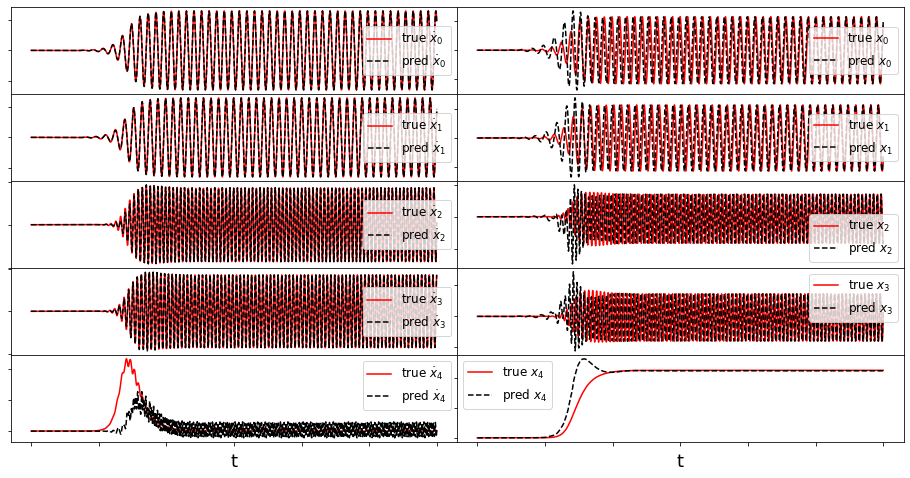

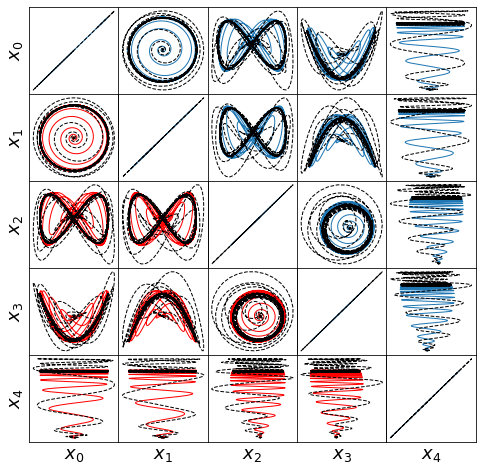

optimal m:  [-1.29999959 -0.61930844 -2.02222925 -1.45584113  0.41128265]
As eigvals:  [-0.42167528 -0.25814406 -0.16768613 -0.12355753 -0.00909711]
Estimate of trapping region size, Rm =  252.41068533674604
Normalized trapping region size, Reff =  144.58697137926822
(11,) (11,)
Frobenius Error =  0.65585161567428
Time-averaged derivative error =  0.0034749741563702874


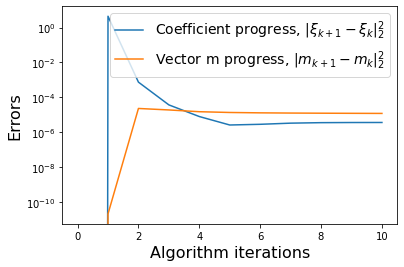

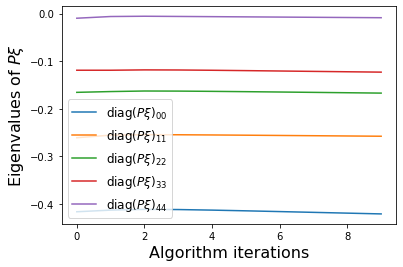

In [16]:
# same test and train trajectory for now, but will try other ICs later
x_train = a
x_test = a

# define hyperparameters
relax_optim = True
if relax_optim:
    max_iter = 10
    eta = 1.0
else:
    max_iter = 10
    eta = 0.1
threshold = 0.1
alpha_m = 5e-1 * eta
alpha_A = 1.0 * eta

constraint_zeros, constraint_matrix = make_constraints(r)

# run trapping SINDy
sindy_opt = ps.TrappingSR3(threshold=threshold, eta=eta, alpha_m=alpha_m, alpha_A=alpha_A, accel=False, 
                           tol_m=1e-10, m0=m_guess, A0=A_guess,
                           max_iter=max_iter, tol=1e-20, gamma=-0.1,
                           constraint_lhs=constraint_matrix,
                           constraint_rhs=constraint_zeros,
                           constraint_order="feature",
                           relax_optim=relax_optim,
                           eps_solver=1e-5)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t, quiet=True)
Xi = model.coefficients().T
xdot_test = model.differentiate(x_test, t=t)
xdot_test_pred = model.predict(x_test)
PL_tensor = sindy_opt.PL_
PQ_tensor = sindy_opt.PQ_
L = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
Q = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
x_train_pred = model.simulate(x_train[0, :], t)
x_test_pred = model.simulate(a0, t)

# plotting and analysis
make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, 'vonKarman')
make_lissajou(r, x_train, x_test, x_train_pred, x_test_pred, 'VonKarman')
mean_val = np.mean(x_test_pred, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_stability(r, Xi, sindy_opt, mean_val)
make_progress_plots(r, sindy_opt)
A_guess = sindy_opt.A_history_[-1]
m_guess = sindy_opt.m_history_[-1]
E_pred = np.linalg.norm(x_test - x_test_pred) / np.linalg.norm(x_test)
print('Frobenius Error = ', E_pred)

# Compute time-averaged dX/dt error
deriv_error = np.zeros(xdot_test.shape[0])
for i in range(xdot_test.shape[0]):
    deriv_error[i] = np.dot(xdot_test[i, :] - xdot_test_pred[i, :], 
                            xdot_test[i, :] - xdot_test_pred[i, :])  / np.dot(
                            xdot_test[i, :], xdot_test[i, :])
print('Time-averaged derivative error = ', np.nanmean(deriv_error))

# Comparing 3D trajectories with the POD-Galerkin model

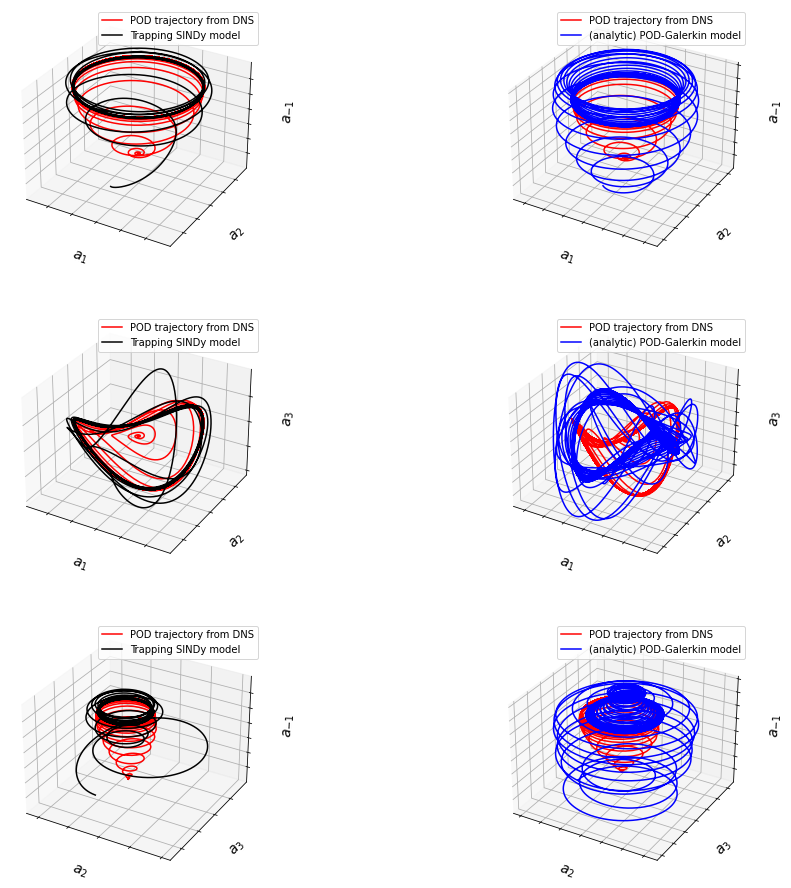

In [17]:
# Interpolate onto better time base
t_traj = np.linspace(t[0], t[-1], len(t) * 10)

# random initial condition near to origin
a0 = (np.random.rand(r) - 0.5) * 2.0

# simulate trapping SINDy results
xtraj = model.simulate(a0, t_traj)

# simulate and plot 9D POD-Galerkin results
a0_galerkin9 = np.zeros(9)
a0_galerkin9[:r-1] = a0[:-1]
a0_galerkin9[-1] = a0[-1]
t_span = (t_traj[0], t_traj[-1])
xtraj_pod9 = solve_ivp(model9, t_span, a0_galerkin9, t_eval=t_traj, **integrator_keywords).y.T

# Make awesome plot
fig, ax = plt.subplots(3, 2, subplot_kw={'projection': '3d'}, figsize=(16, 16))
data = [x_test[:, [0, 1, -1]], xtraj[:, [0, 1, -1]], 
        x_test[:, [0, 1, -1]], xtraj_pod9[:, [0, 1, -1]], 
        x_test[:, [0, 1, 2]], xtraj[:, [0, 1, 2]], 
        x_test[:, [0, 1, 2]], xtraj_pod9[:, [0, 1, 2]], 
        x_test[:, [2, 3, -1]], xtraj[:, [2, 3, -1]], 
        x_test[:, [2, 3, -1]], xtraj_pod9[:, [2, 3, -1]]]
data_labels = [[r'$a_1$', r'$a_2$', r'$a_{-1}$'], 
               [r'$a_1$', r'$a_2$', r'$a_3$'], 
               [r'$a_2$', r'$a_3$', r'$a_{-1}$']]
for i in range(3):
    ax[i, 0].plot(data[4 * i][:, 0], data[4 * i][:, 1], data[4 * i][:, 2], 
                  color='r', label='POD trajectory from DNS')
    ax[i, 0].plot(data[4 * i + 1][:, 0], data[4 * i + 1][:, 1], data[4 * i + 1][:, 2],
                  color='k', label='Trapping SINDy model')
    ax[i, 1].plot(data[4 * i + 2][:, 0], data[4 * i + 2][:, 1], data[4 * i + 2][:, 2],
                  color='r', label='POD trajectory from DNS')
    ax[i, 1].plot(data[4 * i + 3][:, 0], data[4 * i + 3][:, 1], data[4 * i + 3][:, 2],
                  color='b', label='(analytic) POD-Galerkin model')
    ax[i, 0].legend(fontsize=10)
    ax[i, 0].set_xticklabels([])
    ax[i, 0].set_yticklabels([])
    ax[i, 0].set_zticklabels([])
    ax[i, 0].set_xlabel(data_labels[i][0], fontsize=14)
    ax[i, 0].set_ylabel(data_labels[i][1], fontsize=14)
    ax[i, 0].set_zlabel(data_labels[i][2], fontsize=14)
    ax[i, 1].legend(fontsize=10)
    ax[i, 1].set_xticklabels([])
    ax[i, 1].set_yticklabels([])
    ax[i, 1].set_zticklabels([])
    ax[i, 1].set_xlabel(data_labels[i][0], fontsize=14)
    ax[i, 1].set_ylabel(data_labels[i][1], fontsize=14)
    ax[i, 1].set_zlabel(data_labels[i][2], fontsize=14)
plt.show()

optimal m:  [-1.29999959 -0.61930844 -2.02222925 -1.45584113  0.41128265]
As eigvals:  [-0.42167528 -0.25814406 -0.16768613 -0.12355753 -0.00909711]


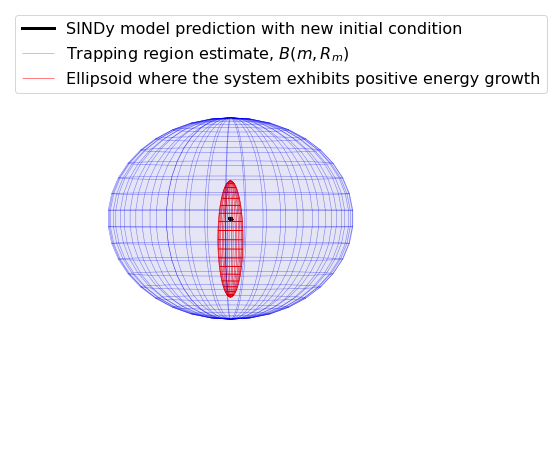

In [18]:
# make 3D illustration of the trapping region
trapping_region(r, x_test_pred, Xi, sindy_opt, 'Von Karman')

### Refit the Trapping SINDy model on the 9D POD system.
We showed that the 5D trapping SINDy model is provably stable, with high performance, so we try again for the 9D system. This model does not fully converge to a provably stable model, but the performance is fairly strong in the first few modes. We will also see that it predicts the transient timing quite well.

 Iteration | Data Error | Stability Error |   L1 Error
           0  1.82647e+00  1.03104e-01  1.46089e+01
           1  1.71245e+00  7.30959e-02  1.37894e+01
           2  1.70739e+00  7.28362e-02  1.37809e+01
           3  1.70559e+00  7.23770e-02  1.37784e+01
           4  1.70386e+00  7.19351e-02  1.37756e+01
           5  1.70212e+00  7.15127e-02  1.37728e+01
           6  1.70038e+00  7.11036e-02  1.37701e+01
           7  1.69863e+00  7.07075e-02  1.37673e+01
           8  1.69689e+00  7.03240e-02  1.37645e+01
           9  1.69515e+00  6.99529e-02  1.37617e+01


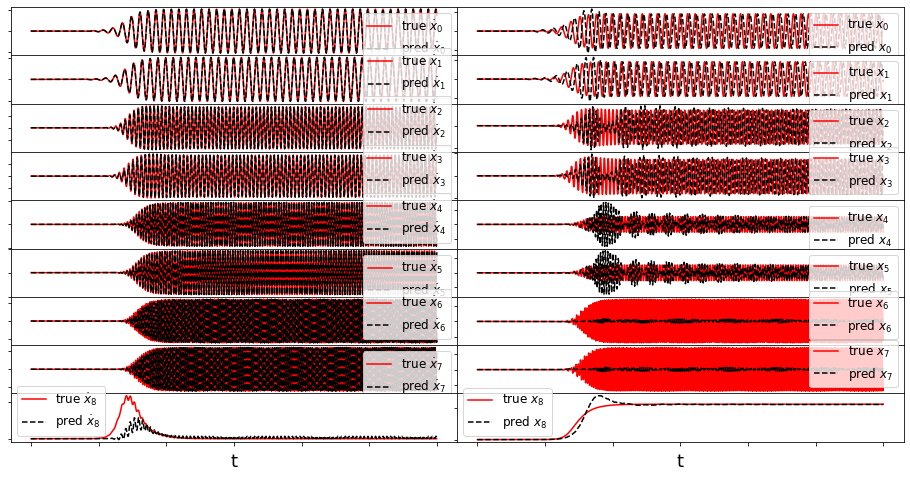

In [19]:
# load in POD modes from DNS again
r = 9
a = np.loadtxt('data/vonKarman_pod/vonKarman_a.dat')
if r < 9:
    a_temp = a[:, 1:r]
    a_temp = np.hstack((a_temp, a[:, -1].reshape(3000, 1)))
    a = a_temp
else:
    a = a[:, 1:r + 1]
a = a[tbegin:tend:skip, :]
x_test9 = a
x_train9 = a
a0 = np.zeros(9)
a0[0] = 1e-3

# initial guesses to speed up convergence
A_guess = np.asarray([[-1.00000000e+00, -6.81701156e-18,  1.64265568e-17,
         1.68310896e-17, -1.46247179e-17, -1.45278659e-17,
        -4.41460518e-17, -9.75820242e-18,  1.06635090e-18],
       [ 2.11962730e-17, -1.00000000e+00,  5.91916098e-17,
         1.02939874e-16,  1.07502638e-17,  1.16153337e-17,
         8.84561388e-17, -2.38407466e-17,  2.25533310e-17],
       [ 7.70290614e-18, -2.37493643e-17, -1.00000000e+00,
         5.74638700e-17, -2.17428595e-18,  2.41426251e-17,
         6.89329350e-18, -3.65633938e-18,  7.79059612e-17],
       [-2.44656476e-17, -6.72113002e-18,  4.74779569e-17,
        -1.00000000e+00, -8.10241368e-18,  6.23271318e-18,
         1.12682516e-18,  3.01538601e-17,  2.94041671e-16],
       [-1.29102703e-16,  1.28776608e-17,  4.48182893e-17,
        -7.15006179e-19, -1.00000000e+00,  4.11221110e-18,
        -3.33172879e-16, -4.22913612e-17, -5.88841351e-17],
       [ 7.10726824e-18,  9.55210532e-18, -5.30624590e-17,
        -1.99630356e-17, -4.88598954e-18, -1.00000000e+00,
        -1.72238787e-17,  1.45840342e-17, -1.29732583e-17],
       [-1.01481442e-17,  4.78393464e-17, -2.53411865e-17,
         1.31394318e-17, -5.96906289e-18,  1.68124806e-18,
        -1.00000000e+00, -1.51574587e-17, -2.15989255e-18],
       [-9.48456158e-18, -5.41527305e-18, -3.05384371e-19,
        -1.99553156e-18,  8.37718659e-17,  6.05188865e-17,
         3.94017953e-17, -1.00000000e+00, -1.69209548e-18],
       [ 2.85170680e-18,  2.40387704e-17,  8.14566833e-17,
         2.74548940e-17, -4.62236236e-18, -7.34952555e-18,
         4.64207566e-18,  1.69214151e-18, -1.00000000e+00]])
m_guess = np.asarray([-1.03179775e+00, -3.31216061e-01, -6.71172384e-01, -6.75994493e-01,
       -8.50522236e-03, -2.12185379e-02, -9.16401064e-04,  1.03271372e-03, 4.70226212e-01])

# define hyperparameters
relax_optim = True
if relax_optim:
    max_iter = 10
    eta = 1.0
else:
    max_iter = 10
    eta = 0.1
threshold = 1
alpha_m = 5e-1 * eta
alpha_A = 1.0 * eta

constraint_zeros, constraint_matrix = make_constraints(r)

# run trapping SINDy
sindy_opt = ps.TrappingSR3(threshold=threshold, eta=eta, alpha_m=alpha_m, alpha_A=alpha_A, accel=False, 
                           tol_m=1e-10, m0=m_guess, A0=A_guess,
                           max_iter=max_iter, tol=1e-20, gamma=-0.1,
                           constraint_lhs=constraint_matrix,
                           constraint_rhs=constraint_zeros,
                           constraint_order="feature",
                           relax_optim=relax_optim,
                           eps_solver=1e-6)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train9, t=t, quiet=True)
Xi = model.coefficients().T
xdot_test9 = model.differentiate(x_test9, t=t)
xdot_test_pred9 = model.predict(x_test9)
PL_tensor = sindy_opt.PL_
PQ_tensor = sindy_opt.PQ_
L = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
Q = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
x_train_pred9 = model.simulate(x_train9[0, :], t)
x_test_pred9 = model.simulate(a0, t)

# plotting and analysis
mean_val = np.mean(x_test_pred, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_stability(r, Xi, sindy_opt, mean_val)
make_fits(r, t, xdot_test9, xdot_test_pred9, x_test9, x_test_pred9, 'vonKarman9')

# Energy plot illustrating the transient and long-time energy conservation

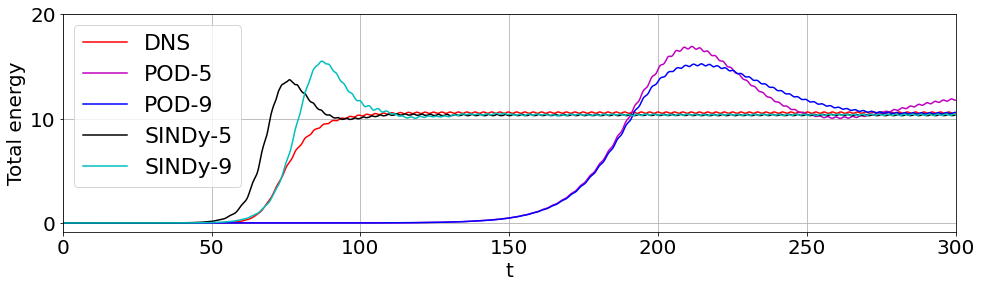

In [20]:
# define energies of the DNS, and both the 5D and 9D models 
# for POD-Galerkin and the trapping SINDy models
E = np.sum(a ** 2, axis=1)
E_galerkin5 = np.sum(a_galerkin5 ** 2, axis=1)
E_galerkin9 = np.sum(a_galerkin9 ** 2, axis=1)
E_sindy5 = np.sum(x_test_pred ** 2, axis=1)
E_sindy9 = np.sum(x_test_pred9 ** 2, axis=1)

# plot the energies
plt.figure(figsize=(16, 4))
plt.plot(t, E, 'r', label='DNS')
plt.plot(t, E_galerkin5, 'm', label='POD-5')
plt.plot(t, E_galerkin9, 'b', label='POD-9')
plt.plot(t, E_sindy5, 'k', label=r'SINDy-5')
plt.plot(t, E_sindy9, 'c', label=r'SINDy-9')

# do some formatting and save
plt.legend(fontsize=22, loc=2)
plt.grid()
plt.xlim([0, 300])
ax = plt.gca()
ax.set_yticks([0, 10, 20])
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
plt.ylabel('Total energy', fontsize=20)
plt.xlabel('t', fontsize=20)
plt.show()

Note that the SINDy models improve on the transient timing, and the 9-mode SINDy model gets it just about right!

### Is the Trapping SINDy model or analytic POD-Galerkin model more sparse?
Below we make a bar plot illustrating that the trapping SINDy model is typically far sparser than the POD-9 model. Moreover we calculate a metric for effective nonlinearity for each model, which we define through
$$S_e = \|\frac{min(Q_{ijj})}{max(Q_{ijj})}\|.$$

POD-9 model, S_e =  0.0012073896847718175
Trapping model, S_e =  1.4939871318621128e-05


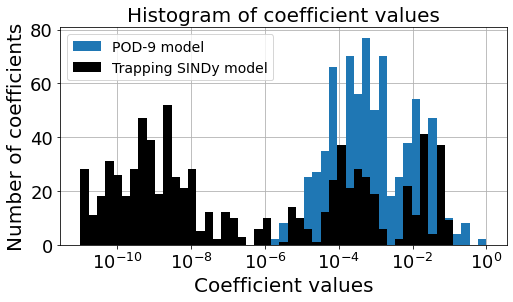

In [21]:
make_bar(galerkin9, L, Q)
min_sum = 100
max_sum = 0
for i in range(r):
    if np.abs(np.sum(np.diag(galerkin9['Q'][i, :, :]))) > max_sum:
         max_sum = np.abs(np.sum(np.diag(galerkin9['Q'][i, :, :])))
    if np.abs(np.sum(np.diag(galerkin9['Q'][i, :, :]))) < min_sum:
         min_sum = np.abs(np.sum(np.diag(galerkin9['Q'][i, :, :])))
print('POD-9 model, S_e = ', min_sum / max_sum)     
min_sum = 100
max_sum = 0
for i in range(r):
    if np.abs(np.sum(np.diag(Q[i, :, :]))) > max_sum:
         max_sum = np.abs(np.sum(np.diag(Q[i, :, :])))
    if np.abs(np.sum(np.diag(Q[i, :, :]))) < min_sum:
         min_sum = np.abs(np.sum(np.diag(Q[i, :, :])))
print('Trapping model, S_e = ', min_sum / max_sum)     

Key takeaway: the trapping SINDy is far sparser than the analytic POD-9 model, which is really nice. One potential caveat is that the metric for effective nonlinearity is quite a bit smaller, meaning it the trapping theorem only very weakly applies to this model (so it is hard to get to fully stable models). This make sense because the optimization problem itself seems to struggle to find provably stable models for this problem.

# Plot $u(x,y,t)$ reconstructions and modes

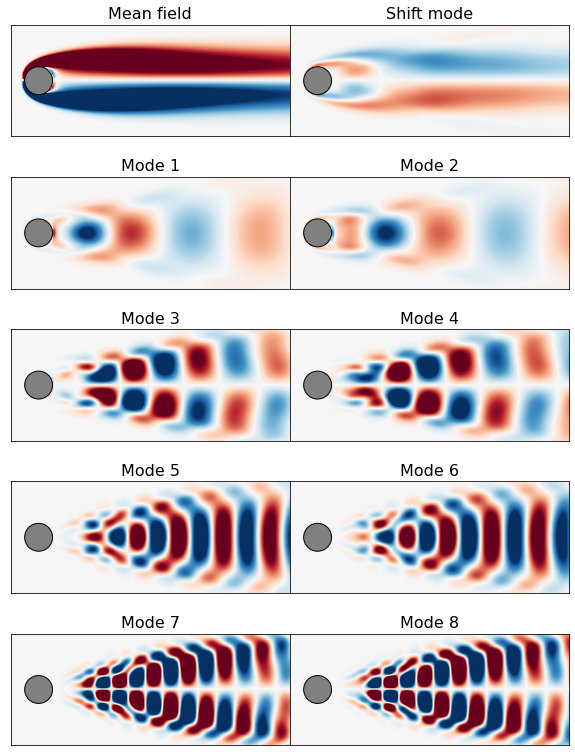

In [22]:
from scipy.interpolate import griddata
# path to POD mode files
field_path = 'data/vonKarman_pod/cyl0.snapshot'  
mode_path = 'data/vonKarman_pod/pod_modes/'  

# Read limit cycle flow field for grid points
field = nek.readnek(field_path)
nel = 2622  # Number of spectral elements
nGLL = 7  # Order of the spectral mesh
n = nel * nGLL ** 2

# define cell values needed for the vorticity interpolation
Cx = np.array([field.elem[i].pos[0, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])
Cy = np.array([field.elem[i].pos[1, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])

filename = lambda t_idx: 'cyl0.f{0:05d}'.format(t_idx)

# plot mean + leading POD modes
clim = [-1, 1]
file_order = [1, 10, 2, 3, 4, 5, 6, 7, 8, 9]
file_labels = ['Mean field', 'Shift mode', 'Mode 1', 'Mode 2', 'Mode 3', 
               'Mode 4', 'Mode 5', 'Mode 6', 'Mode 7', 'Mode 8']
fig = plt.figure(figsize=(10, 14))
spec = gridspec.GridSpec(ncols=2, nrows=5, figure=fig, hspace=0.0, wspace=0.0)
for i in range(len(file_order)):
    plt.subplot(spec[i])
    vort = interp( get_vorticity(mode_path + filename(file_order[i])) )
    plot_field(np.reshape(vort, [nx, ny], order='F').T, clim=clim, label=file_labels[i])
    plt.xlim([-1, 9])
    plt.ylim([-2, 2])
    ax = plt.gca()
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.title(file_labels[i], fontsize=16)

plt.show()

### Make $u(x,y,t)$ reconstruction animations
Note that memory errors may result... each reconstruction is a 80000 x 3000 or 80000 x 5000 matrix

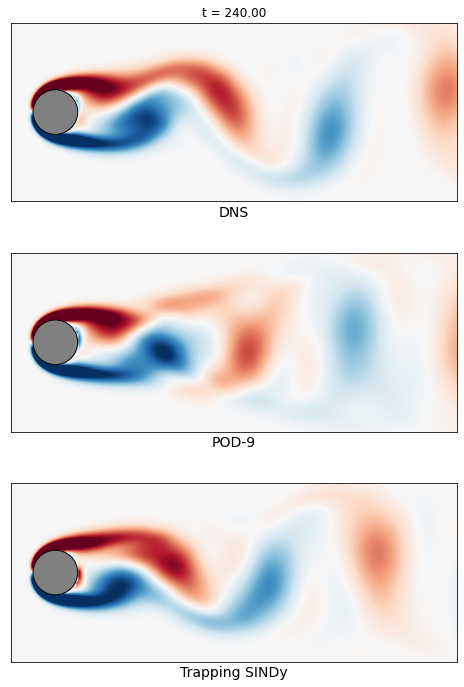

In [23]:
from matplotlib import animation

# Define the full u(x, y, t) fields for the DNS, POD-Galerkin reconstruction
# and trapping SINDy reconstruction. 
u_true = np.zeros((vort.shape[0], a.shape[0]))
u_galerkin = np.zeros((vort.shape[0], a_galerkin9.shape[0]))
u_sindy = np.zeros((vort.shape[0], a.shape[0]))
n = 128478
Psi = np.zeros([n, r])
Psi0 = get_vorticity(mode_path + filename(1))
r = 9
for i in range(r):
    Psi[:, i] = get_vorticity(mode_path + filename(i + 2))
    
# for reconstruction with the shift-mode
Psi0 = get_vorticity(mode_path + filename(1))
Psi_mean = np.outer(Psi0, np.ones(a.shape[0]))
u_true = Psi_mean + Psi @ a.T
u_sindy = Psi_mean + Psi @ x_test_pred9.T
Psi_mean = np.outer(Psi0, np.ones(a_galerkin9.shape[0]))
u_galerkin = Psi_mean + Psi @ a_galerkin9.T

# make the animation
fps = 30
fig = plt.figure(1, figsize=(8, 12) )
# plot DNS 
clim = [-3, 3]
tbegin = 400
tend = 2500
plt.subplot(3, 1, 1)
im1 = plot_field(np.reshape(interp(u_true[:, tbegin]), [nx, ny], order='F').T, 
                 clim=clim, label='DNS')
plt.xlim([-1, 9])
plt.ylim([-2, 2])
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('t = {0:.2f}'.format(t[tbegin]))
plt.xlabel('DNS', fontsize=14)
# plot POD-Galerkin reconstruction
plt.subplot(3, 1, 2)
im2 = plot_field(np.reshape(interp(u_galerkin[:, tbegin]), [nx, ny], order='F').T, 
                 clim=clim, label='POD-9')
plt.xlim([-1, 9])
plt.ylim([-2, 2])
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.xlabel('POD-9', fontsize=14)
# plot trapping SINDy reconstruction
plt.subplot(3, 1, 3)
im3 = plot_field(np.reshape(interp(u_sindy[:, tbegin]), [nx, ny], order='F').T, 
                 clim=clim, label='Trapping SINDy')
plt.xlim([-1, 9])
plt.ylim([-2, 2])
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.xlabel('Trapping SINDy', fontsize=14)
# switch back to subplot 1 
plt.subplot(3, 1, 1)
ax = plt.gca()


# animation function for looping through frames
def animate_func(i):
    if i % 100:
        print(i)
    ax.set_title('t = {0:.2f}'.format(t[i]))
    im1.set_array(np.reshape(interp(u_true[:, i]), [nx, ny], order='F').T)
    im2.set_array(np.reshape(interp(u_galerkin[:, i]), [nx, ny], order='F').T)
    im3.set_array(np.reshape(interp(u_sindy[:, i]), [nx, ny], order='F').T)
    return [im1, im2, im3]


anim = animation.FuncAnimation(fig, 
                               animate_func, 
                               frames = np.arange(tbegin, tend, 500),
                               interval = 25)
anim.save('vonKarman_meanfield.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])